# Miniproject 2: Melody generation

## Introduction

### Description

To develop a model employing ANN on real-world data requires going through several major steps, each of which with important design choices that directly impact the end results. In this project, we guide you through these choices starting from a large database of [Irish folk melodies](https://github.com/IraKorshunova/folk-rnn/tree/master/data) to your own model of symbolic music composition. 


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. Please ensure that your notebook is fully executed before handing it in. 

## Functions and imports

For your convenience we import some libraries and provide some functions below. Some libraries (`midi` and `music21==5.1.0`) should be added. If you work with the docker image, pull it `docker pull zifeo/artificial-neural-networks:cpu` before to get the latest version where these libraries are added and stop/relaunch the container (as stated in the instructions https://github.com/zifeo/artificial-neural-networks). If you work locally, be sure to import them. If you do not find the midi library for python3, install it with `python setup.py install` inside the `python3-midi` folder after cloning https://github.com/louisabraham/python3-midi.git.

Finally, fill in your sciper number(s) for the random seed and simply run the following cell.

In [1]:
sciper = {'student_1': 252281, 
          'student_2': 0}
seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 8, 4

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

import midi
import music21

Using TensorFlow backend.


In [2]:
def plotMelody(P, T, dictionaries, PrP=None, PrT=None, H=None):
    """
    P: The pitch array (integer representation) or matrix (one-hot encoding)
    T: The duration array (integer representation) or matrix (one-hot encoding)
    dictionaries: The dictionaries relating integer to a pitch or duration
    PrP: (Optional) If provided with PrT, plot the transition probabilities
    PrT: (Optional) If provided with PrP, plot the transition probabilities
    H: (Optional) Add a plot with the hidden state dynamic sorted by frequency
    """
    P = np.asarray(P)
    T = np.asarray(T)
    if len(P.shape) == 1:#if array
        P = np_utils.to_categorical(P, len(dictionaries['P']))
    if len(T.shape) == 1:#if array
        T = np_utils.to_categorical(T, len(dictionaries['T']))
    
    xlim = [-1,np.where(P==1)[0][-1]+1]
    
    activeidxes = np.where(np.sum(P, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrP is not None:
        targets = np.where(P[:,activeidxes]==1)
        plt.imshow(PrP[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.') 
    else:
        plt.imshow(P[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["P"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$P[n]$")
    plt.xlim(xlim)
    plt.show()
    
    activeidxes = np.where(np.sum(T, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrT is not None:
        targets = np.where(T[:,activeidxes]==1)
        plt.imshow(PrT[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.')
    else:
        plt.imshow(T[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["T"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$T[n]$")
    plt.xlim(xlim)
    plt.show()
    
    
    if H is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H[:xlim[1]-1,k], H[1:xlim[1],k])] for k in range(H.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H = H[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,np.where(T==1)[0][-1]+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("$H[n]$")
        plt.show()


def plotLearningCurves(History):
    
    log = History.history
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_loss'], '--', c=c[0], label='Pitch train loss')
    plt.plot(log['val_YP_loss'], c=c[0], label='Pitch val loss')
    
    plt.plot(log['YT_loss'], '--', c=c[1], label='Dur train loss')
    plt.plot(log['val_YT_loss'], c=c[1], label='Dur val loss')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_acc'], '--', c=c[0], label='Pitch train acc')
    plt.plot(log['val_YP_acc'], c=c[0], label='Pitch val acc')
    
    plt.plot(log['YT_acc'], '--', c=c[1], label='Dur train acc')
    plt.plot(log['val_YT_acc'], c=c[1], label='Dur val acc')
    plt.legend(loc='best')
    
def plotLearningCurves2(History1, History2):
    
    log1 = History1.history
    log2 = History2.history
    
    plt.figure(figsize=(8,4))
    plt.plot(log1['YP_loss'], '--', c=c[0], label='RNN : Pitch train loss')
    plt.plot(log1['val_YP_loss'], c=c[0], label='RNN : Pitch val loss')
    plt.plot(log2['YP_loss'], '--', c=c[2], label='GRU : Pitch train loss')
    plt.plot(log2['val_YP_loss'], c=c[2], label='GRU : Pitch val loss')
    
    plt.plot(log1['YT_loss'], '--', c=c[1], label='RNN : Dur train loss')
    plt.plot(log1['val_YT_loss'], c=c[1], label='RNN : Dur val loss')
    plt.plot(log2['YT_loss'], '--', c=c[3], label='GRU : Dur train loss')
    plt.plot(log2['val_YT_loss'], c=c[3], label='GRU : Dur val loss')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.plot(log1['YP_acc'], '--', c=c[0], label='RNN : Pitch train acc')
    plt.plot(log1['val_YP_acc'], c=c[0], label='RNN : Pitch val acc')
    plt.plot(log2['YP_acc'], '--', c=c[2], label='GRU : Pitch train acc')
    plt.plot(log2['val_YP_acc'], c=c[2], label='GRU : Pitch val acc')
    
    plt.plot(log1['YT_acc'], '--', c=c[1], label='RNN : Dur train acc')
    plt.plot(log1['val_YT_acc'], c=c[1], label='RNN : Dur val acc')
    plt.plot(log2['YT_acc'], '--', c=c[3], label='GRU : Dur train acc')
    plt.plot(log2['val_YT_acc'], c=c[3], label='GRU : Dur val acc')
    plt.legend(loc='best')
    
def plotLearningCurves_loss(History1, History2):
    
    log1 = History1
    log2 = History2
    
    plt.figure(figsize=(8,4))
    plt.plot(log1['val_YP_loss'], c=c[0], label='RNN : Pitch val loss')
    plt.plot(log2['val_YP_loss'], c=c[2], label='GRU : Pitch val loss')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.plot(log1['val_YT_loss'], c=c[1], label='RNN : Dur val loss')
    plt.plot(log2['val_YT_loss'], c=c[3], label='GRU : Dur val loss')
    plt.legend(loc='best')
    
    
def plotLearningCurves_acc(History1, History2):
    
    log1 = History1
    log2 = History2
    
    plt.figure(figsize=(8,4))
    plt.plot(log1['val_YP_acc'], c=c[0], label='RNN : Pitch val acc')
    plt.plot(log2['val_YP_acc'], c=c[2], label='GRU : Pitch val acc')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))    
    plt.plot(log1['val_YT_acc'], c=c[1], label='RNN : Dur val acc')
    plt.plot(log2['val_YT_acc'], c=c[3], label='GRU : Dur val acc')
    plt.legend(loc='best')

def sample(preds, temperature=1.):
    """Helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def writeMIDI(xP, xT, dictionaries, label):

    # Instantiate a MIDI Pattern (contains a list of tracks)
    pattern = midi.Pattern(format = 0, resolution=480)
    # Instantiate a MIDI Track (contains a list of MIDI events)
    track = midi.Track()
    # Append the track to the pattern
    pattern.append(track)
    Events = []
    
    pseq = [dictionaries['P'][p] for p in xP]
    tseq = [dictionaries['T'][t] for t in xT]
    for t, p in zip(tseq, pseq):
        e = midi.NoteOnEvent(tick=0, velocity=90, pitch=p)
        track.append(e)
        e = midi.NoteOffEvent(tick=t, velocity=0, pitch=p)
        track.append(e)
        
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    # Save the pattern to disk
    midi.write_midifile(label, pattern)

## Exercise 1 : Data processing
### Description

For a real world application of ANNs, the original data should be translated into a representation understandable by an ANN. This step is often neglected but is of outmost importance. In order for you to better understand how ANN are applied to real world problems, the first step of this miniproject will guide you through a possible representation. 

Note that in general, your representation should be normalized in order to obtain homogeneous data from which a structure can be extracted by your ANN model. Importantly, all processing steps toward your representation should not (or minimally) distort your original data.

To represent MIDI files, we provide you with a Python MIDI library. You should then

0. Download the MIDI tar file from [this link](https://github.com/IraKorshunova/folk-rnn/tree/master/data) and put it in a folder named "chorpus" at the same level of this notebook.
1. Parse the chorpus to extract the label of (a random subset of) the data (code is provided)
2. Read each MIDI file in the subset with the midi [library](https://github.com/louisabraham/python3-midi)
3. For each data sequence extract the sequence of MIDI notes defined by two dimensions ("P": the sequence of note pitches (integer between 0 and 127 representing a piano key), "T": the sequence of note durations.
4. Select two melodies and display them both as sequences of MIDI events and sequence of notes in two dimensions. Control that your representation is correct.

For step 3, you should learn how MIDI files are constructed. Below, we give a minimal explanation and some code for this particular project. For a more complete explanation, look for MIDI in your favorite search engine. Given this dataset, you can observe that it is monophonic (one note at a time) and there's a small delay (1 tick) inbetween each note. You could decide to ignore this delay or correct (recommanded) for it.

A MIDI files is composed of timed events of many kinds. For this project, we focus on the events related to notes being played or stopped. Those are MIDI events "Note Off" and "Note On". Each event is timed with respect with the previous one (dt). The duration of a note is therefore given by the cummulated dt inbetween the event associated to a note's onset and the event associated with the same note's offset.
        

### Minimal code to read MIDI files

In [3]:
def display(midi_file="chorpus/sessiontune0.mid"):
    #index 0 for first track only
    events = midi.read_midifile(midi_file)[0] 
    tick = 0
    print(midi_file)
    print("#"*40)
    print("tick \t pitch \t message \t velocity")
    print("#"*40+'\n')
    for n, event in enumerate(events):
        tick += event.tick
        if event.name in ['Note On', 'Note Off']:
            if n<13 or n>len(events)-10:
                print("%i \t %i \t %s \t %i"%(tick, event.data[0], event.name, event.data[1]))
            if n in range(20,23):
                print(". \t . \t . \t \t .")
    print("#"*40+'\n')

display()

datapath = "chorpus/"
dataset = {}
np.random.seed(seed)

for filename in os.listdir(datapath):
    if filename.endswith("mid"):
        label = filename[:-4]
        #Down sample dataset
        if np.random.rand() < 0.1:
            dataset[label] = {"T":[], "P": []}
print("%i/%i melodies retained"%(len(list(dataset.keys())), len(os.listdir(datapath))))

chorpus/sessiontune0.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 67 	 Note On 	 105
240 	 67 	 Note Off 	 0
241 	 64 	 Note On 	 80
480 	 64 	 Note Off 	 0
481 	 64 	 Note On 	 80
720 	 64 	 Note Off 	 0
721 	 64 	 Note On 	 95
1200 	 64 	 Note Off 	 0
1201 	 62 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
33601 	 67 	 Note On 	 80
33840 	 67 	 Note Off 	 0
33841 	 69 	 Note On 	 95
34080 	 69 	 Note Off 	 0
34081 	 71 	 Note On 	 80
34320 	 71 	 Note Off 	 0
34321 	 72 	 Note On 	 80
34560 	 72 	 Note Off 	 0
########################################

4342/44301 melodies retained


### Solution

In [4]:
def is_polyphonic(midi_file):
    midi_file = datapath+label+".mid"
    events = midi.read_midifile(midi_file)[0] #index 0 for first track only  
    noteOn = True
    for n, event in enumerate(events):
        
        if event.name in ['Note On']:
            if (noteOn != True):
                return True
            else:
                noteOn = False
            
        elif event.name in ['Note Off']:
            if (noteOn != False):
                return True
            else:
                noteOn = True

the code below was used to remove polyphonic example

In [5]:
## get all the files
#dataset_tmp = {}
#for filename in os.listdir(datapath):
#    if filename.endswith("mid"):
#        label = filename[:-4]
#        dataset_tmp[label] = {"T":[], "P": []}
#
## remove polyphonic example
#for label in list(dataset_tmp.keys()):
#    midi_file = datapath+label+".mid"
#    if (is_polyphonic(midi_file)):
#        # remove polyphonic example
#        if os.path.isfile(midi_file):
#            os.remove(midi_file)
#

In [6]:
import os.path
def parseMIDI(midi_file):
    events = midi.read_midifile(midi_file)[0] #index 0 for first track only  
    T = []
    P = []
    for n, event in enumerate(events):
        #insert your code here...
        
        # already have preprocess the data so that it cannot have polyphonic example
        if event.name in ['Note Off']:
            P.append(event.data[0])
            T.append(event.tick -1) # -1 to correct the in-between delay of 1
        
    return P, T

for label in list(dataset.keys()):
    Pseq, Tseq = parseMIDI(datapath+label+".mid")
    dataset[label]['T']= Tseq
    dataset[label]['P']= Pseq

for label in np.random.choice(list(dataset.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print('/n')


sessiontune29960
MIDI events
chorpus/sessiontune29960.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 63 	 Note On 	 105
720 	 63 	 Note Off 	 0
721 	 58 	 Note On 	 95
960 	 58 	 Note Off 	 0
961 	 63 	 Note On 	 80
1200 	 63 	 Note Off 	 0
1201 	 66 	 Note On 	 80
1440 	 66 	 Note Off 	 0
1441 	 61 	 Note On 	 105
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
44881 	 63 	 Note On 	 80
45120 	 63 	 Note Off 	 0
45121 	 61 	 Note On 	 80
45360 	 61 	 Note Off 	 0
45361 	 63 	 Note On 	 95
45840 	 63 	 Note Off 	 0
45841 	 61 	 Note On 	 80
46080 	 61 	 Note Off 	 0
########################################

Note representation
{'P': [63, 58, 63, 66, 61, 56, 61, 65, 63, 58, 63, 66, 65, 63, 61, 63, 61, 63, 58, 63, 66, 61, 56, 61, 65, 63, 70, 68, 65, 66, 63, 61, 63, 61, 63, 58, 63, 66, 61, 56, 61, 65, 63, 58, 63, 66, 65, 63, 61, 63, 61, 63, 58, 63, 66, 61, 56, 61, 65, 63, 70, 68, 65, 66, 63, 61, 63, 65, 66, 61, 

## Exercise 2: Tokenzation and translation to integer
### Description

Now you should have a "dataset" dictionary where each entry corresponds to one melody example from a subset of the full dataset. In turn, every melody example is represented by a dictionary with two sequences: the "P" entry being the sequence of pitches and the "T" entry, the sequence of durations. Here, you will implement the first steps to translate this dataset in a language that can be read by your ANN models. To achieve that, we will later use the [one-hot encoding scheme](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), which will associate each input (and output) unit of your network to a unique pitch or duration. In your network, these units will then be sequentially activated in the same order as their corresponding pitch/duration in your dataset. And at each note, the model will be trained to approximate the probability distributions of the upcoming pitch and duration.

1. Gather in a list of all possible pitches and durations in your dataset. These two lists will be your "dictionaries" translating a pitch/duration to a unique integer between 0 and the number of entries (-1) in the pitch/duration dictionary.
2. Translate the pitch/duration sequence of each melody to the integer representation.
3. Select randomly two melodies and display them in the note representation and translated to integer. Check that the translation is correct.

### Solution

### 1.

In [7]:
# Gather in a list of all pitches and durations in your dataset, that will be used to create the dictionary
def get_all_seq(dataset):
    all_seq = dict()
    all_seq['T'] = []
    all_seq['P'] = []
    for melody in dataset:
        all_seq['T'] += dataset[melody]['T']
        all_seq['P'] += dataset[melody]['P']
    return all_seq

In [8]:
def create_dict(all_seq):
    dictionaries = {}
    # trick to remove duplicates
    set_T = set(all_seq['T'])
    set_P = set(all_seq['P'])
    list_T = list(set_T)
    list_P = list(set_P)
    list_T.sort()
    list_P.sort()
    
    dictionaries['T'] = dict([(t, i) for i, t in enumerate(list_T)])
    dictionaries['P'] = dict([(p, i) for i, p in enumerate(list_P)])
    
    return dictionaries

In [9]:
all_seq = get_all_seq(dataset)
dictionaries = create_dict(all_seq)
dictionaries

{'P': {48: 0,
  49: 1,
  50: 2,
  51: 3,
  52: 4,
  53: 5,
  54: 6,
  55: 7,
  56: 8,
  57: 9,
  58: 10,
  59: 11,
  60: 12,
  61: 13,
  62: 14,
  63: 15,
  64: 16,
  65: 17,
  66: 18,
  67: 19,
  68: 20,
  69: 21,
  70: 22,
  71: 23,
  72: 24,
  73: 25,
  74: 26,
  75: 27,
  76: 28,
  77: 29,
  78: 30,
  79: 31,
  80: 32,
  81: 33,
  82: 34,
  83: 35,
  84: 36,
  85: 37,
  86: 38,
  87: 39,
  88: 40,
  89: 41,
  90: 42,
  91: 43,
  92: 44,
  93: 45,
  94: 46},
 'T': {28: 0,
  38: 1,
  58: 2,
  78: 3,
  88: 4,
  94: 5,
  118: 6,
  158: 7,
  178: 8,
  198: 9,
  238: 10,
  278: 11,
  318: 12,
  358: 13,
  418: 14,
  478: 15,
  538: 16,
  558: 17,
  598: 18,
  638: 19,
  718: 20,
  798: 21,
  838: 22,
  958: 23,
  1038: 24,
  1078: 25,
  1118: 26,
  1198: 27,
  1278: 28,
  1438: 29,
  1678: 30,
  1758: 31,
  1918: 32,
  2158: 33,
  2398: 34,
  2638: 35,
  2718: 36,
  2878: 37,
  3118: 38,
  3838: 39}}

### 2.

In [10]:
# Translate the pitch/duration sequence in the dataset to integer
def translate(dataset, dictionaries):
    translated_dataset = {}
    
    for label in list(dataset.keys()):
        translated_dataset[label] = {}
        translated_dataset[label]['T'] = [dictionaries['T'][key] for key in dataset[label]['T']]
        translated_dataset[label]['P'] = [dictionaries['P'][key] for key in dataset[label]['P']]
        
    return translated_dataset

In [11]:
dataset = translate(dataset, dictionaries)

### 3.

In [12]:
for label in np.random.choice(list(dataset.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print('/n')

sessiontune36663
MIDI events
chorpus/sessiontune36663.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 56 	 Note On 	 105
480 	 56 	 Note Off 	 0
481 	 65 	 Note On 	 105
960 	 65 	 Note Off 	 0
961 	 65 	 Note On 	 80
1200 	 65 	 Note Off 	 0
1201 	 63 	 Note On 	 80
1440 	 63 	 Note Off 	 0
1441 	 65 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
44401 	 61 	 Note On 	 80
44640 	 61 	 Note Off 	 0
44641 	 63 	 Note On 	 80
44880 	 63 	 Note Off 	 0
44881 	 65 	 Note On 	 80
45120 	 65 	 Note Off 	 0
45121 	 61 	 Note On 	 105
46080 	 61 	 Note Off 	 0
########################################

Note representation
{'P': [8, 17, 17, 15, 17, 18, 17, 13, 8, 17, 17, 15, 17, 18, 15, 8, 15, 15, 13, 15, 17, 15, 12, 8, 15, 15, 13, 15, 17, 13, 8, 17, 17, 15, 17, 18, 17, 13, 8, 17, 17, 15, 17, 18, 15, 8, 15, 15, 13, 15, 17, 15, 12, 8, 15, 15, 13, 15, 17, 13, 17, 18, 20, 20, 22, 20, 18, 15, 15, 17, 18, 18,

the translation is correct

## Exercise 3: Data reprocessing
### Description

Before moving to the implementation of your RNN generative model of note transition, you will perform data exploration and modification. This step will allow your model to get the most out of your original data as well as ensuring some features such as transposition invariance. 

To further improve your model, you might want to reconsider your original data. Many different approaches can be undertaken. Here you are asked to implement the a rare event suppression method and transposition invariance.

**Rare event suppression** If a unit in your network is associated to a duration that happens very rarely in your data, a possible simplification consists in removing the melodies conaining these rare events from your dataset. 
1. Plot and comment the histogram of durations in your entire dataset. Use the labels from the original duration values (rather than the integer representation). 
2. Based on your observations, remove from your dataset melodies containing very rare durations. Adjust the rejection threshold such that at most 5% of the melodies are dicarded with this step. 
3. Recompute the duration dictionary based on your filtered dataset and plot the new histogram of durations. 

**Transposition invariance** A melody is perceived similarly by the human ear if it's shifted up or down by a constant offset (see [transposition](https://en.wikipedia.org/wiki/Transposition_(music))). Here, you will force your model to be transposition invariant. For this you can choose to use one of two orthogonal methods. The first consists in transposing every melody into a common tonality (C Major/A minor). On the other hand, the second consists in transposing each melody in all possible keys. The second method will increase your dataset size by a factor bigger than 11! As the training time is directly related with the dataset size, to save computing time, we recomand that you implement the first option.

***Pitch normalization*** 
1. Use the provided function to create a new dataset where all melodies are transposed to C Major/A minor. 
2. Plot the histograms of the pitches before and after transposition.

Finally, you shoud recompute the tokenization step for your brand new filtered and normalized dataset.

### Solution

### Rare event suppression

#### 1.

In [13]:
# compute inverse dictionaries
dictionaries_inv = {}
dictionaries_inv['T'] = {v: k for k, v in dictionaries['T'].items()}
dictionaries_inv['P'] = {v: k for k, v in dictionaries['P'].items()}

(array([  7.19876000e+05,   1.04415000e+05,   5.95200000e+03,
          1.49000000e+03,   2.93000000e+02,   3.70000000e+01,
          9.50000000e+01,   3.80000000e+01,   8.00000000e+00,
          6.00000000e+00]),
 array([   28.,   409.,   790.,  1171.,  1552.,  1933.,  2314.,  2695.,
         3076.,  3457.,  3838.]),
 <a list of 10 Patch objects>)

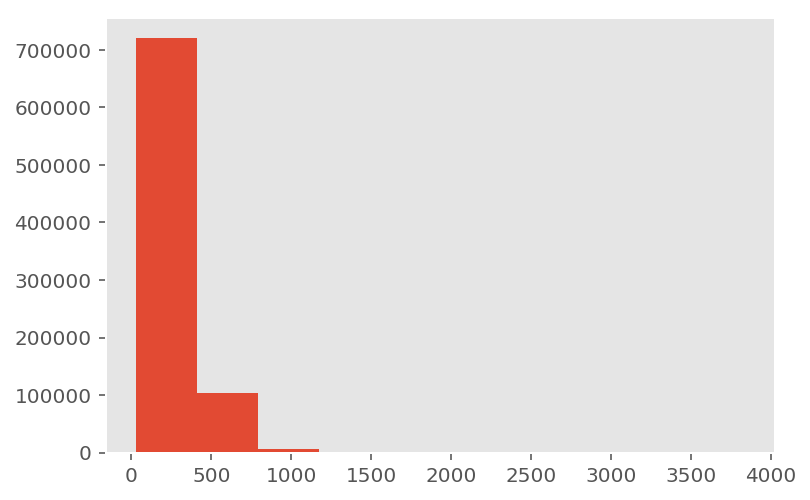

In [14]:
plt.hist(all_seq['T'])

Zoom in range (0,500)

(array([  3.32000000e+02,   1.48310000e+04,   4.46210000e+04,
          5.98030000e+04,   5.73493000e+05,   7.00000000e+00,
          2.58070000e+04,   9.82000000e+02,   2.00000000e+00,
          8.56040000e+04]),
 array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
         450.,  500.]),
 <a list of 10 Patch objects>)

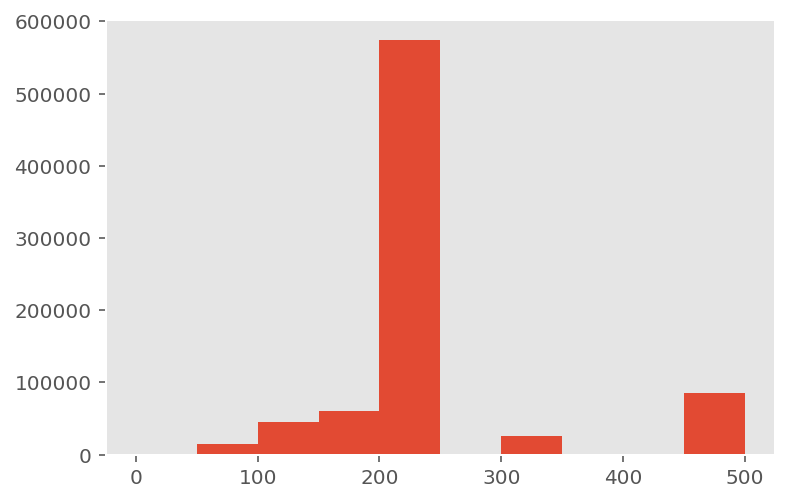

In [15]:
plt.hist(all_seq['T'], range = (0, 500))

From the histograms above we can see that the majority are concentrated in the range 0 to 500 and after zooming in that interval, we see that the majority are between 200 and 250.
From our dictionnary we have two value in that range, 238 and 278.

To get an idea exactly which duration are rare, we will compute below the number of occurence for each duration in our dictionary

In [16]:
keys = []
for i in dictionaries['T']:
    keys.append(i)

keys.sort()
x =[]
y = []
for i in keys:
    x.append(i)
    y.append(all_seq['T'].count(i))
    
dict_dur_occ = dict(zip(x, y))
dict_dur_occ

{28: 100,
 38: 232,
 58: 12011,
 78: 2782,
 88: 18,
 94: 20,
 118: 44621,
 158: 59609,
 178: 188,
 198: 6,
 238: 573493,
 278: 7,
 318: 25807,
 358: 982,
 418: 2,
 478: 85604,
 538: 8,
 558: 5,
 598: 41,
 638: 81,
 718: 18674,
 798: 392,
 838: 51,
 958: 5500,
 1038: 2,
 1078: 5,
 1118: 2,
 1198: 313,
 1278: 23,
 1438: 1154,
 1678: 60,
 1758: 2,
 1918: 231,
 2158: 37,
 2398: 92,
 2638: 3,
 2718: 2,
 2878: 36,
 3118: 8,
 3838: 6}

In [17]:
max(list(dict_dur_occ.values()))

573493

Here we can see that the duration 238 is the most frequent (that confirm what we say before) and that there still rare duration  in the range of (0,500) like 88, 94, 198, 278

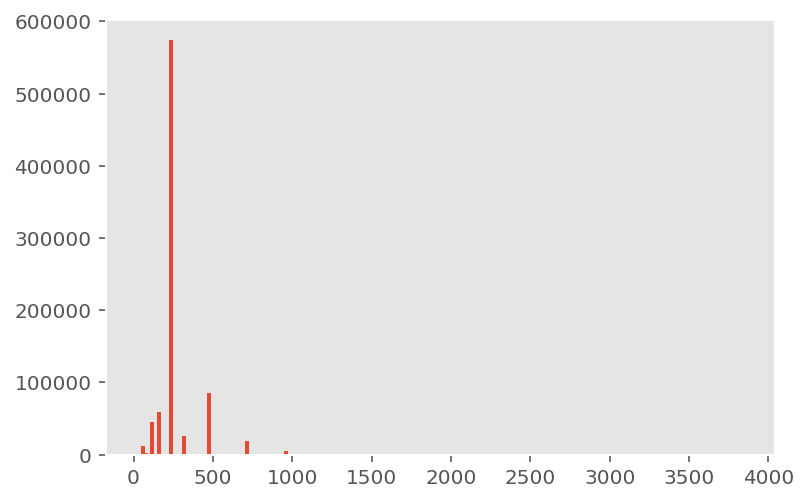

In [18]:
#plt.figure(figsize=(20,10))
plt.bar(dict_dur_occ.keys(), dict_dur_occ.values(), width = 25, align='center')
#plt.xticks(x, x)
#plt.yticks(y, y)
plt.show()

#### 2.

I selected a threshold of 100 meaning that durations that have less that 100 occurence in the whole dataset are selected and melody containing those selected duration will be removed

In [19]:
TH_REJECT = 100
duration_to_remove = []
for i in dict_dur_occ:
    if dict_dur_occ[i] < TH_REJECT:
        #print(i)
        duration_to_remove.append(dictionaries['T'][i])
        
print(len(duration_to_remove),"/", len(dict_dur_occ))

23 / 40


We see that we have more than half of the duration in our dictionary will be removed.

In [20]:
#  remove from your dataset melodies containing very rare durations.
dataset_before = dataset.copy()
skip = False
for k, v in list(dataset.items()):
    for dur in v['T']:
        if (dur in duration_to_remove):        
            del dataset[k]
            skip = True
        if (skip):
            skip = False
            break;
print("nb melody removed",len(dataset_before)-len(dataset))
print("percentage removed : ",1-(len(dataset)/len(dataset_before)))

nb melody removed 100
percentage removed :  0.023030861354214616


#### 3.

(array([  1.14562000e+05,   5.91668000e+05,   8.19510000e+04,
          1.79810000e+04,   5.05100000e+03,   0.00000000e+00,
          2.72000000e+02,   8.89000000e+02,   0.00000000e+00,
          7.00000000e+01]),
 array([   28.,   217.,   406.,   595.,   784.,   973.,  1162.,  1351.,
         1540.,  1729.,  1918.]),
 <a list of 10 Patch objects>)

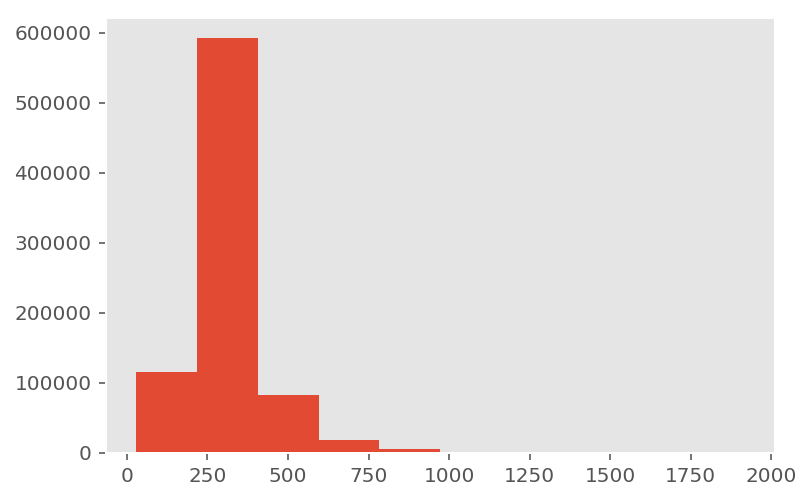

In [21]:
# map back to be able to recompute the dict      
dataset = translate(dataset, dictionaries_inv)

# Recompute the duration dictionary based on your filtered dataset and plot the new histogram of durations.
all_seq = get_all_seq(dataset)
dictionaries = create_dict(all_seq)

plt.hist(all_seq['T'])

after the supression, we can notice that the x-axis has shrink from 4000 to 2000

### Pitch normalization

(array([  1.52300000e+03,   1.96510000e+04,   7.43780000e+04,
          1.69990000e+05,   1.75879000e+05,   2.17539000e+05,
          1.21099000e+05,   2.61250000e+04,   6.12900000e+03,
          1.31000000e+02]),
 array([ 48. ,  52.6,  57.2,  61.8,  66.4,  71. ,  75.6,  80.2,  84.8,
         89.4,  94. ]),
 <a list of 10 Patch objects>)

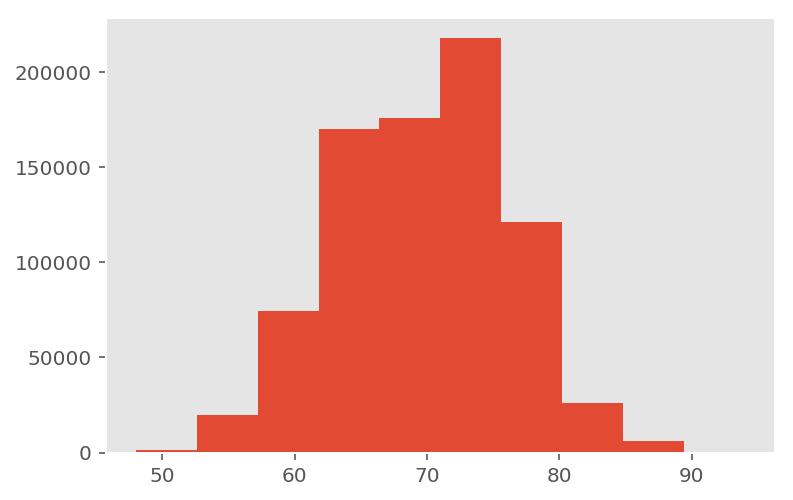

In [22]:
# plot the pitch before transposition
plt.hist(all_seq['P'])

In [23]:
def transposeDataset(dataset):
    transposed_dataset = {}

    for label in list(dataset.keys()):
        transposed_dataset[label] = {}
        score = music21.converter.parse(datapath+label+".mid")
        key = score.analyze('key')
        if key.mode == "major":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('C'))
        elif key.mode == "minor":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('A'))
        i = i.semitones
        transposed_dataset[label]['P'] = [p+i for p in dataset[label]['P']]
        transposed_dataset[label]['T'] = dataset[label]['T']
        
    return transposed_dataset

In [24]:
dataset_transp = transposeDataset(dataset)

# Recompute the duration dictionary based on the transposed dataset
all_seq = get_all_seq(dataset_transp)
dictionaries = create_dict(all_seq)

(array([  1.29500000e+03,   6.41500000e+03,   4.34960000e+04,
          1.86029000e+05,   2.02825000e+05,   2.04471000e+05,
          1.44082000e+05,   2.13630000e+04,   2.29300000e+03,
          1.75000000e+02]),
 array([ 43. ,  48.5,  54. ,  59.5,  65. ,  70.5,  76. ,  81.5,  87. ,
         92.5,  98. ]),
 <a list of 10 Patch objects>)

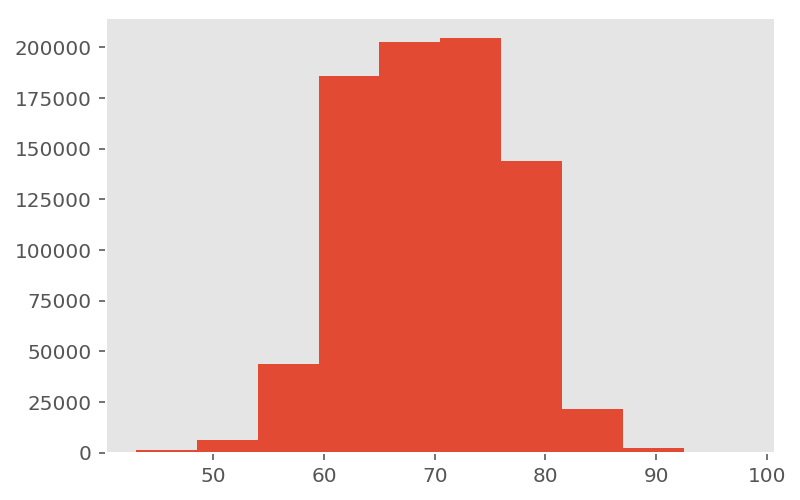

In [25]:
# plot the pitch after transposition
plt.hist(all_seq['P'])

In [26]:
# translate with the new dictionnaries
dataset = translate(dataset_transp, dictionaries)

**Question**: How much did you reduce the space of possible durations with your rare event suppression procedure? What is the impact in term of training time?
    
**Answer**: I remove 23 out of 40 (more than half), I choose duration that were below a threshold (100) in the whole dataset. this remove approximately 2% of the dataset. In term of the training time, since we have more than half of the duration, the training time will be greatly reduced for the prediction of the duration.

**Question**: Explain why and how both transposition to a single tonality and to all possible tonalities can yield transposition invariance in your model. 

**Answer**: if we transpose all the melodies to a single tonality (like we did), all the melodies will be "normalized" (shift to a common origin) and so it will the model will be constrained to learn in that range, thus being transposition invariant. On the other hand if we transpose all melodies to all possible tonalities, the model will be able to learn to be shift (transposition) invariant from all this new sample but it will requires a lot of time to train the model.

**Question**: In terms of number of dimensions, what would have been the impact of keeping the joint represenation of a note duration and pitch (vs separating the two features)? 

**Answer**: keeping the joint representation would have a made the number of dimensions exponential and therefore would have increased considerably the training time. Separating the feature reduce greatly the number of dimension and training time.

**Question**: How would the distribution of notes in the joint representation differ from the distributions in the pitch and duration only representations (as shown by your histograms above)?

**Answer**: it will be more scarce, a lot of small bins.


## Exercise 4: One-hot and zero-padding
### Description

The last few steps to be able to feed (note by note) your music scores to a RNN model are
1. Transform the sequence of integers into a sequence of vectors in the one-hot encoding scheme.
2. Homegenize the length of each sequence

**One-hot encode** You can implement your own integer to one-hot code. For this use the numpy library and the suitable datatype. Alternatively, Keras provides a [built in one-hot encoding scheme](https://keras.io/utils/#to_categorical). After this step, for each melody, you should have two similar length matrices with one representing the sequence of note pitches and the other the sequence of note durations.
1. Code the integer representation into matrices of one-hot vectors

**Zero-padding** Most deep learning libraries, including Keras, require that you specify the shape of the input data. As such, you cannot have variable length inputs per-se. The trick to handle them is [zero-padding](https://keras.io/preprocessing/sequence/#pad_sequences). Provided with the [Masking Layer](https://keras.io/layers/core/#masking) Keras will then ignore time steps where all inputs are 0.
1. Extend the end of each melody matrices with vectors containing only zeros until all melodies have the same size. For simplicity, use the Keras pad_sequences function. There might be some rare very long melodies in your dataset, a possible choice is to set the 'maxlen' argument of pad_sequences to the mean+2std of the melody lengths. This ensure that 95% of your melodies would end before being truncated.
2. Check and display the dimension of the resulting tensors. Typically, the tensor representing the sequence of pitches should be of shape [number of melodies x number of notes x number of entries in the pitch dictionary] and the tensor representing the sequence of durations [number of melodies x number of notes x number of entries in the duration dictionary]

To check if this step was done correctly use the provided plotMelody function. For two randomly selected melodies, call the plotMelody function before and after one-hot/zero-pad. You should obtain the same plots (or slightly truncated if you randomly selected one belonging to 5% longest).

Finally, we strongly suggest that you save your preprocessed data now.

### Solution

### One-hot encode

In [27]:
def encode(dataset, num_classes_T, num_classes_P):
    encoded_dataset = {}
    
    for label in list(dataset.keys()):

        encoded_dataset[label] = {}
        encoded_dataset[label]['T'] = keras.utils.to_categorical(dataset[label]['T'], num_classes=num_classes_T)
        encoded_dataset[label]['P'] = keras.utils.to_categorical(dataset[label]['P'], num_classes=num_classes_P)
        
    return encoded_dataset

In [28]:
encoded_dataset = encode(dataset, len(dictionaries['T']), len(dictionaries['P']))

### Zero-padding

compute the mean

In [29]:
mean = 0
for melody in dataset:
    mean += len(dataset[melody]['T'])
mean /= len(dataset)
mean

191.52380952380952

compute the std

In [30]:
variance = 0
# compute the std
for melody in dataset:
    variance += (len(dataset[melody]['T'])-mean)**2

variance /= len(dataset) - 1
std = np.sqrt(variance)
std

103.66826285433092

In [31]:
max_len = int(mean+(2*std))
max_len

398

In [32]:
def zero_padding(dataset, max_len):
    padded_dataset = {}
    
    for label in list(dataset.keys()):

        padded_dataset[label] = {}
        padded_dataset[label]['T'] = pad_sequences(dataset[label]['T'].T, padding='post', maxlen=max_len).T
        padded_dataset[label]['P'] = pad_sequences(dataset[label]['P'].T, padding='post', maxlen=max_len).T
        
    return padded_dataset

In [33]:
padded_dataset = zero_padding(encoded_dataset, max_len)

check that the tensor is of correct shape

In [34]:
print(len(encoded_dataset))
print(padded_dataset['sessiontune35340']['T'].shape)

4242
(398, 17)


the shape is what we expect, there is 4242 in total, and there is 17 entry in our dictionnary for the duration, after the zero padding, each melody has a length of 398

In [35]:
# compute the invert dictionnary
dictionaries_inv = {}
dictionaries_inv['T'] = {v: k for k, v in dictionaries['T'].items()}
dictionaries_inv['P'] = {v: k for k, v in dictionaries['P'].items()}

sessiontune9111
before one-hot/zero-pad


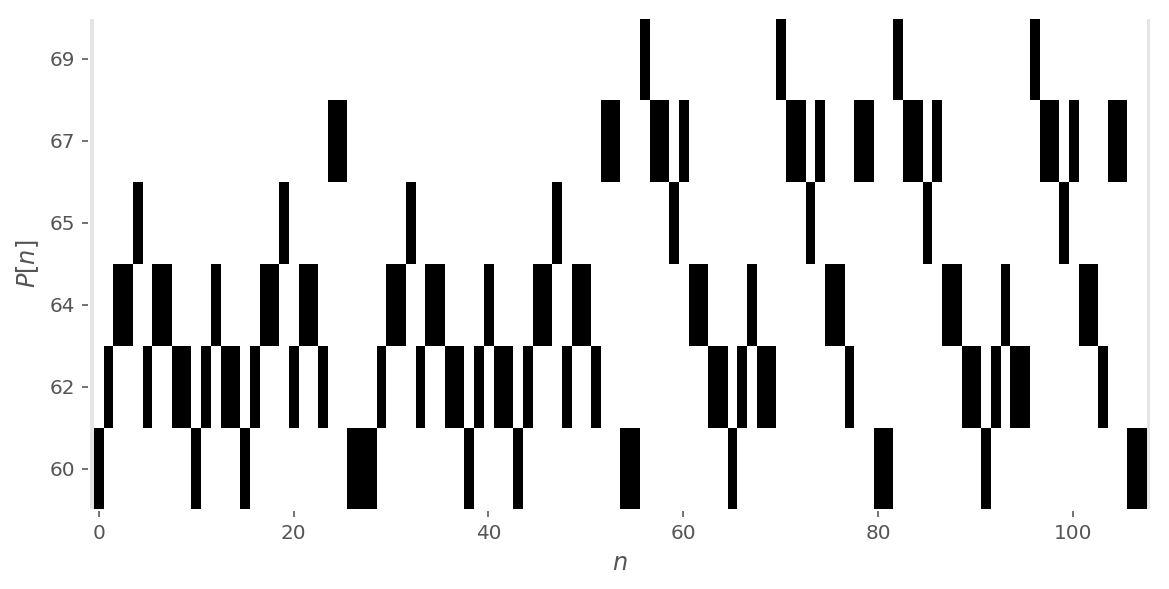

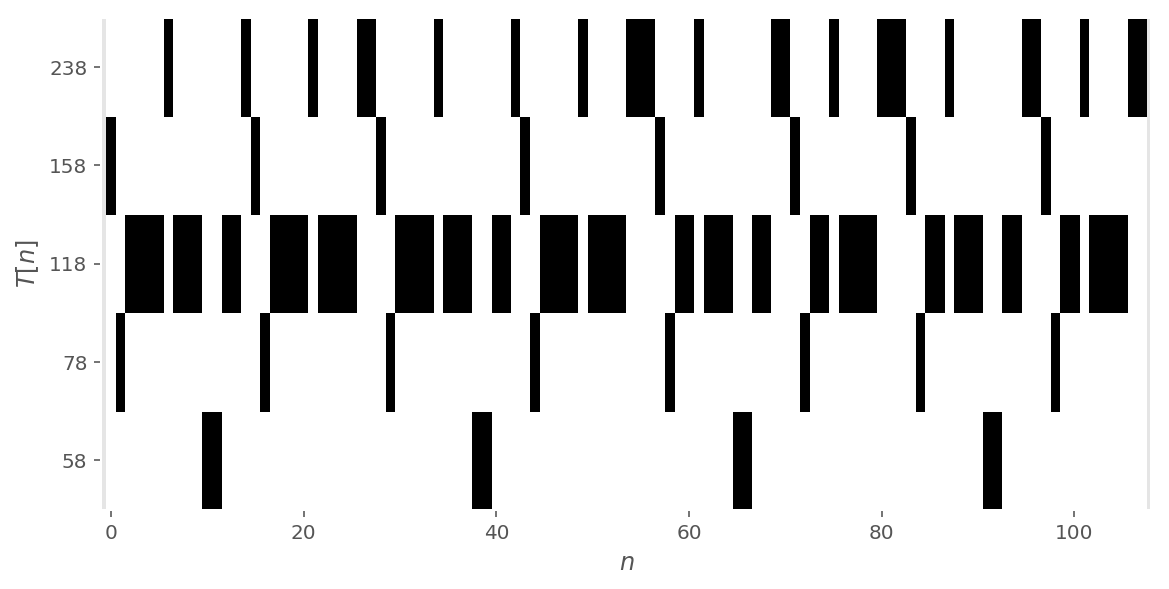

after one-hot/zero-pad


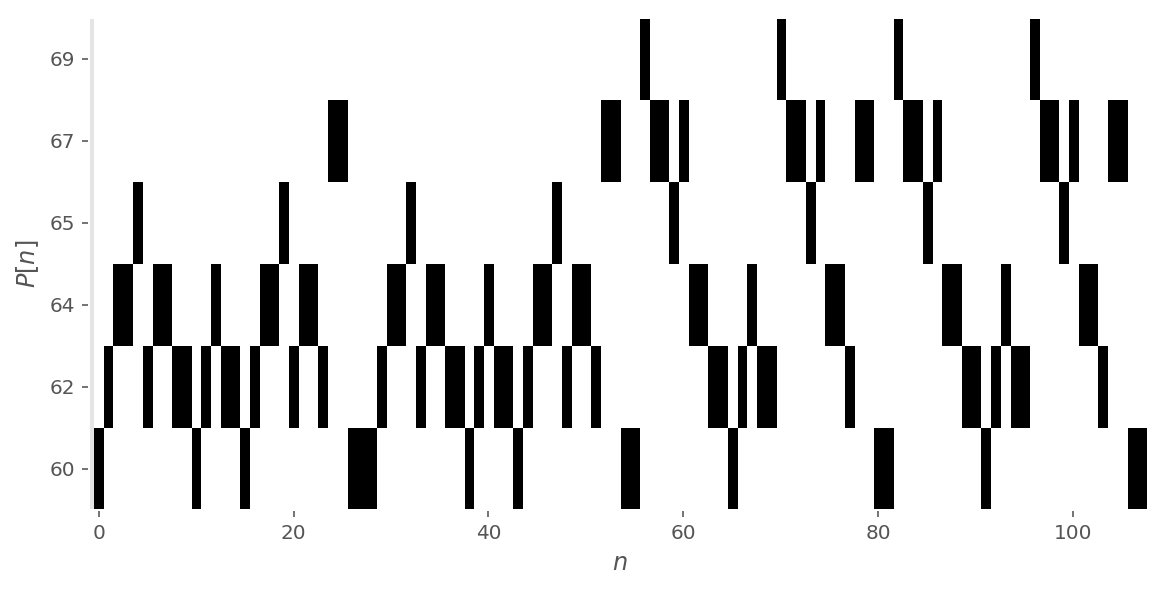

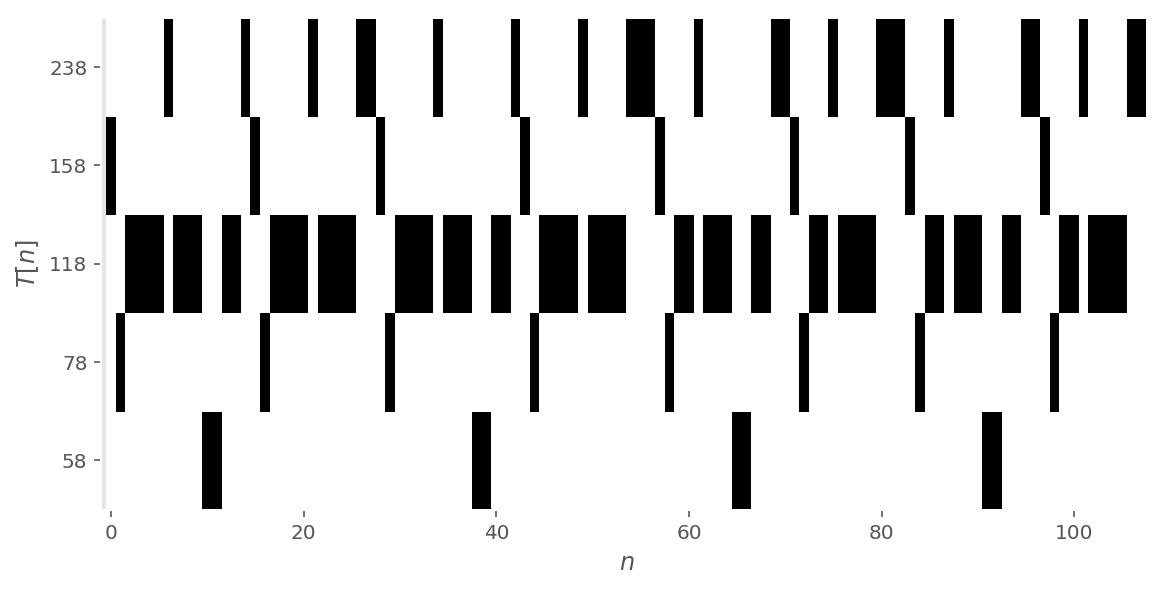

sessiontune4386
before one-hot/zero-pad


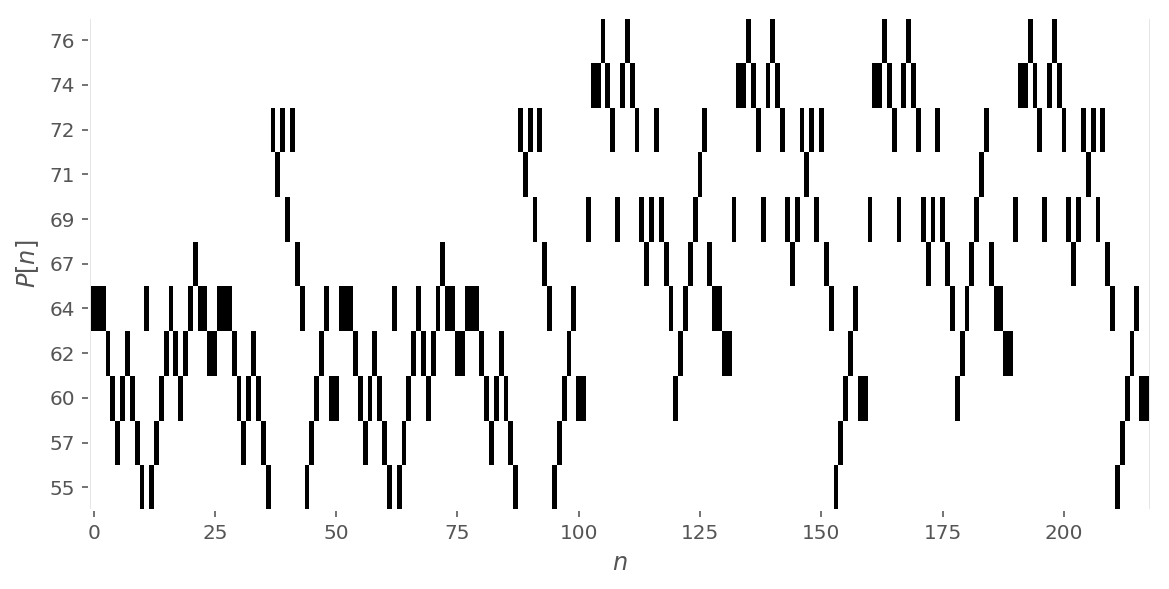

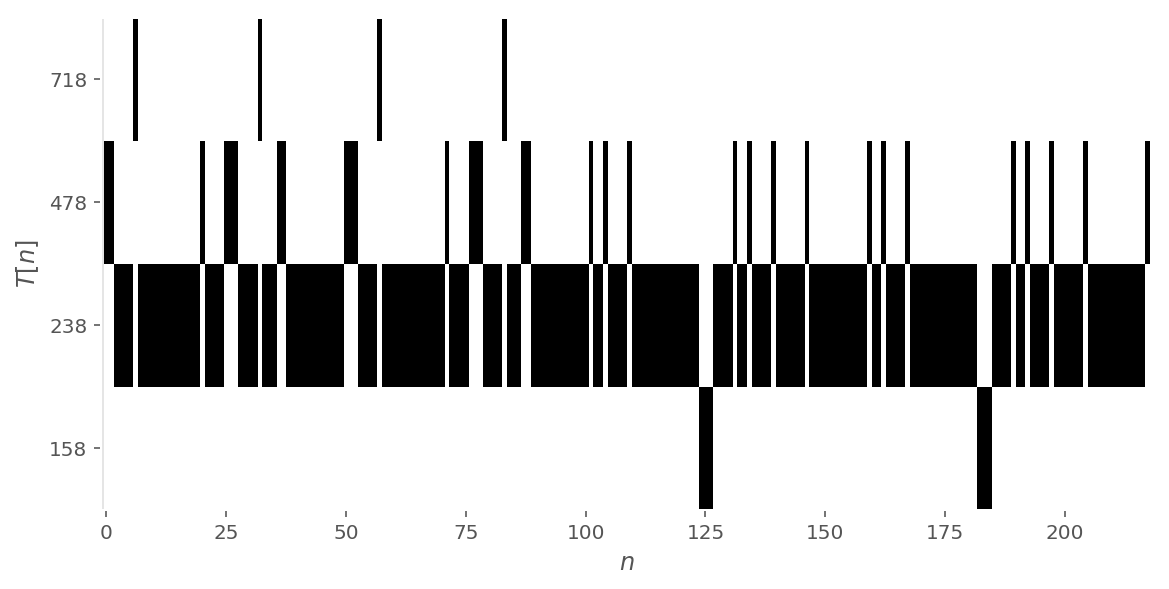

after one-hot/zero-pad


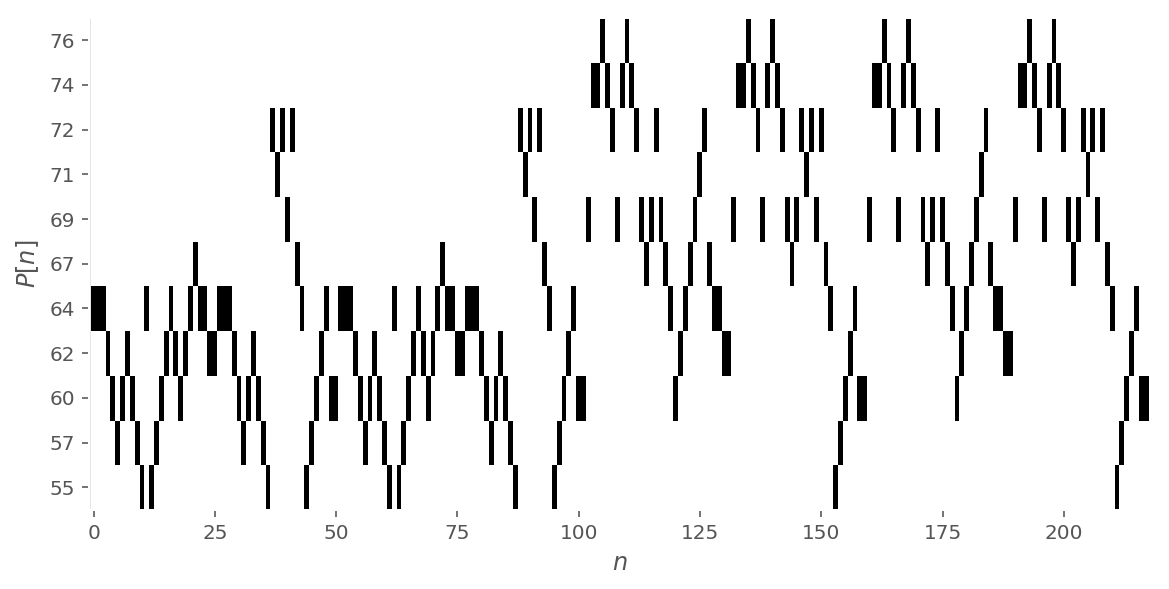

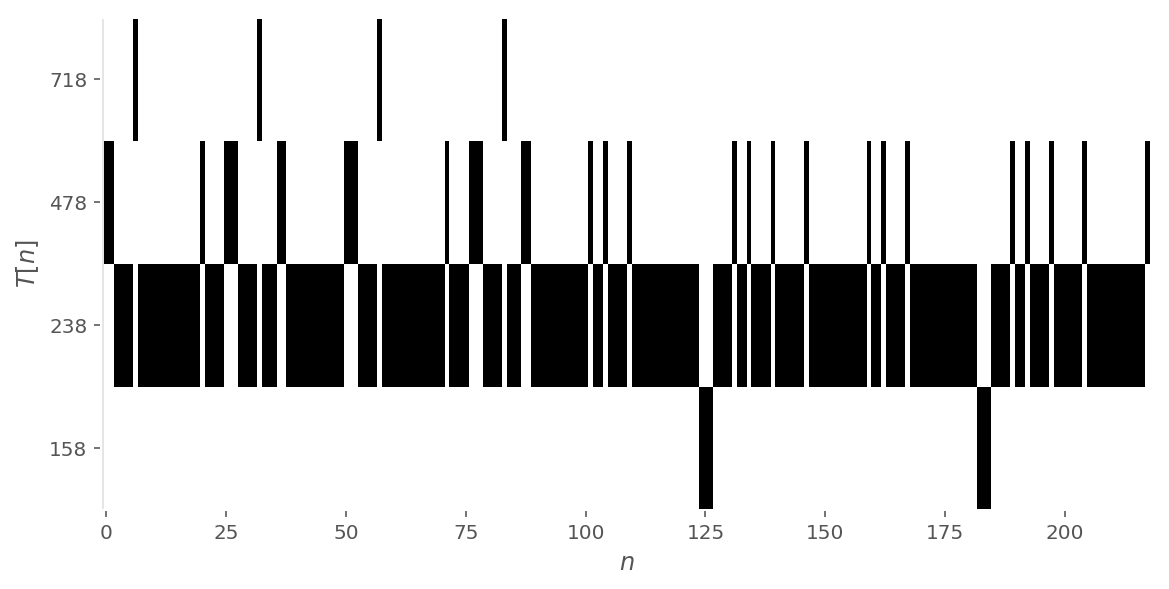

In [36]:
# check if zero padding is OK
for label in np.random.choice(list(dataset.keys()), 2):
    print(label)
    print("before one-hot/zero-pad")
    plotMelody(dataset[label]['P'], dataset[label]['T'],dictionaries_inv)
    print("after one-hot/zero-pad")
    plotMelody(padded_dataset[label]['P'], padded_dataset[label]['T'],dictionaries_inv)

### Save Data

In [42]:
import pickle

# save final dataset
f = open("dataset.pkl","wb")
pickle.dump(padded_dataset,f)
f.close()

# save dictionaries
f = open("dictionaries.pkl","wb")
pickle.dump(dictionaries,f)
f.close()

# save dictionaries
f = open("dictionaries_inv.pkl","wb")
pickle.dump(dictionaries_inv,f)
f.close()

### Restore Data

In [37]:
import pickle
file = open("dataset.pkl",'rb')
dataset = pickle.load(file)
file.close()

file = open("dictionaries.pkl",'rb')
dictionaries = pickle.load(file)
file.close()

file = open("dictionaries_inv.pkl",'rb')
dictionaries_inv = pickle.load(file)
file.close()

## Exercise 5: Building and training a generative model of  note transition with the Keras functional API
### Description

The Keras Sequential model is very efficient for fast prototyping, however suffers from a lack of design liberty. The Keras Functional API is only slightly more complex but allows for more control on the different parts of your model. You will be using the Functional API for the rest of this project. Please read carefully the [documentation](https://keras.io/getting-started/sequential-model-guide/). 

Here, you will be constructing your RNN model of note transition. To achieve that, your model should be trained to approximate the probability distribution of the upcoming note (observed as two output softmax layers - one for pitch and one for duration) given the current note (given as input) and the model internal representation of the history of notes (its hidden state). To achieve that, set the Keras RNN layer argument "return_sequences" to True when building your model. Doing this will give you an output for each note, rather than a single output at the end of the sequence. During training, the target at each time step is the next note pitch and duration.

You are free to use your own architecture but make sure to use at least 128 hidden units, Masking, and dropout to prevent overfitting. Your model should have two output (softmax) layers, one related to the pitch predictions that you should name `YP`, and the other related to the duration predictions `YT`. You should monitor both the loss (categorical_crossentropy) and the accuracy. For your best model, you should reach 40%/75% accuracy on the pitch/duration predictions.

1. Train your first model composed of SimpleRNN cells for min 250 epochs and save the model/parameters that lead to the higher accuracy on the validating set. Use a validation split of 0.2. Try  If you correctly named the output layers (`YP` and `YT`) use the provided `plotLearningCurves(History)` function to plot the learning curves by giving the History object returned by the Keras fit function as argument.  
2. Train a second model where you replaced the SimpleRNN units with GRUs (LSTM unit equivalent that requires less parameters). Make sure you use the same hyperparameters as before. Plot the learning curves.
3. On a single plot, adapt the `plotLearningCurves(History)` function to compare the validation learning curves of the simpleRNN and GRU models. In other words, plot the validation loss vs epoch for pitch/duration for the simpleRNN and GRU models. Do the same for accuracies.


### Solution

In [38]:
batch_length = dataset['sessiontune35340']['T'].shape[0]

In [8]:
def buildModel(dictionaries, batch_length, dropout=0.2, activation='GRU', Hsize=128):
    X = dict()
    H = dict()
    M = dict()
    Y = dict()
    
    X['T'] = Input(shape=(batch_length, len(dictionaries['T'])), name="XT")
    X['P'] = Input(shape=(batch_length, len(dictionaries['P'])), name="XP")
    
    M['T'] = Masking(mask_value=0., name="MT")(X['T'])
    M['P'] = Masking(mask_value=0., name="MP")(X['P'])
    
    H['1'] = Concatenate(name="MergeX")([M['T'], M['P']])
    
    if activation == 'GRU':
        #Your hidden layer(s) architecture with GRU
        H['2'] = GRU(Hsize, return_sequences=True, dropout = dropout, name="H2")(H['1'])
    #elif activation == 'LSTM':
        #Your hidden layer(s) architecture with LSTM (For your own curiosity, not required for the project)
    elif activation == 'RNN':
        #Your hidden layer(s) architecture with SimpleRNN
        H['2'] = SimpleRNN(Hsize,return_sequences=True, dropout = dropout, name="H2")(H['1'])
    
    Y['T'] = TimeDistributed(Dense(len(dictionaries['T']), activation='softmax'), name='YT')(H['2'])#Input(s) to duration output layer)
    Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(H['2'])#Input(s) to pitch output layer)
    
    model = Model(inputs = [X['T'], X['P']], outputs = [Y['T'], Y['P']])
    opt = Adam()
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=opt,
        metrics=['acc'])
    
    return model

#### Format the data for the model

In [38]:
X = {}
Y = {}

X['T'] = np.zeros((len(dataset), batch_length-1, len(dictionaries['T'])))
X['P'] = np.zeros((len(dataset), batch_length-1, len(dictionaries['P'])))

Y['T'] = np.zeros((len(dataset), batch_length-1, len(dictionaries['T'])))
Y['P'] = np.zeros((len(dataset), batch_length-1, len(dictionaries['P'])))

for i, label in enumerate(list(dataset.keys())):
    
    X['T'][i] = dataset[label]['T'][:-1]
    X['P'][i] = dataset[label]['P'][:-1]
    
    Y['T'][i] = dataset[label]['T'][1:]
    Y['P'][i] = dataset[label]['P'][1:]
    
x_train = [X['T'], X['P']]
y_train = [Y['T'], Y['P']]

In [39]:
# shape of tensor of durations
x_train[0].shape

(4242, 397, 17)

In [40]:
# shape of the tensor of pitches
x_train[1].shape

(4242, 397, 53)

#### With SimpleRNN

In [28]:
RNNmodel = buildModel(dictionaries, 
                      batch_length=batch_length-1,#Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      activation='RNN')
RNNmodel.summary()

history_RNN = RNNmodel.fit(x_train, y_train, epochs=250, validation_split = 0.2, verbose=2, batch_size=128)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 397, 17)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 397, 53)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 397, 17)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 397, 53)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

Epoch 30/250
 - 39s - loss: 2.8034 - YT_loss: 0.7641 - YP_loss: 2.0393 - YT_acc: 0.7742 - YP_acc: 0.2926 - val_loss: 2.6826 - val_YT_loss: 0.7246 - val_YP_loss: 1.9580 - val_YT_acc: 0.7838 - val_YP_acc: 0.3213
Epoch 31/250
 - 39s - loss: 2.7935 - YT_loss: 0.7620 - YP_loss: 2.0315 - YT_acc: 0.7748 - YP_acc: 0.2942 - val_loss: 2.6643 - val_YT_loss: 0.7153 - val_YP_loss: 1.9490 - val_YT_acc: 0.7842 - val_YP_acc: 0.3224
Epoch 32/250
 - 39s - loss: 2.7874 - YT_loss: 0.7598 - YP_loss: 2.0276 - YT_acc: 0.7749 - YP_acc: 0.2959 - val_loss: 2.6708 - val_YT_loss: 0.7166 - val_YP_loss: 1.9542 - val_YT_acc: 0.7835 - val_YP_acc: 0.3217
Epoch 33/250
 - 39s - loss: 2.7876 - YT_loss: 0.7611 - YP_loss: 2.0264 - YT_acc: 0.7738 - YP_acc: 0.2958 - val_loss: 2.6508 - val_YT_loss: 0.7105 - val_YP_loss: 1.9402 - val_YT_acc: 0.7869 - val_YP_acc: 0.3245
Epoch 34/250
 - 39s - loss: 2.7756 - YT_loss: 0.7567 - YP_loss: 2.0189 - YT_acc: 0.7757 - YP_acc: 0.2978 - val_loss: 2.6496 - val_YT_loss: 0.7127 - val_YP_loss:

 - 37s - loss: 2.6843 - YT_loss: 0.7277 - YP_loss: 1.9567 - YT_acc: 0.7873 - YP_acc: 0.3166 - val_loss: 2.5330 - val_YT_loss: 0.6704 - val_YP_loss: 1.8625 - val_YT_acc: 0.8036 - val_YP_acc: 0.3454
Epoch 70/250
 - 37s - loss: 2.6816 - YT_loss: 0.7271 - YP_loss: 1.9544 - YT_acc: 0.7844 - YP_acc: 0.3176 - val_loss: 2.5171 - val_YT_loss: 0.6606 - val_YP_loss: 1.8564 - val_YT_acc: 0.8035 - val_YP_acc: 0.3463
Epoch 71/250
 - 38s - loss: 2.6672 - YT_loss: 0.7171 - YP_loss: 1.9500 - YT_acc: 0.7890 - YP_acc: 0.3179 - val_loss: 2.5185 - val_YT_loss: 0.6593 - val_YP_loss: 1.8592 - val_YT_acc: 0.8042 - val_YP_acc: 0.3444
Epoch 72/250
 - 38s - loss: 2.6678 - YT_loss: 0.7165 - YP_loss: 1.9513 - YT_acc: 0.7879 - YP_acc: 0.3179 - val_loss: 2.5128 - val_YT_loss: 0.6572 - val_YP_loss: 1.8557 - val_YT_acc: 0.8037 - val_YP_acc: 0.3447
Epoch 73/250
 - 40s - loss: 2.6662 - YT_loss: 0.7156 - YP_loss: 1.9505 - YT_acc: 0.7895 - YP_acc: 0.3166 - val_loss: 2.5088 - val_YT_loss: 0.6563 - val_YP_loss: 1.8525 - val

 - 38s - loss: 2.6144 - YT_loss: 0.6946 - YP_loss: 1.9198 - YT_acc: 0.7945 - YP_acc: 0.3265 - val_loss: 2.4606 - val_YT_loss: 0.6379 - val_YP_loss: 1.8227 - val_YT_acc: 0.8097 - val_YP_acc: 0.3540
Epoch 109/250
 - 38s - loss: 2.6198 - YT_loss: 0.7032 - YP_loss: 1.9166 - YT_acc: 0.7927 - YP_acc: 0.3276 - val_loss: 2.4648 - val_YT_loss: 0.6451 - val_YP_loss: 1.8198 - val_YT_acc: 0.8087 - val_YP_acc: 0.3541
Epoch 110/250
 - 38s - loss: 2.6127 - YT_loss: 0.6984 - YP_loss: 1.9143 - YT_acc: 0.7945 - YP_acc: 0.3276 - val_loss: 2.4598 - val_YT_loss: 0.6375 - val_YP_loss: 1.8223 - val_YT_acc: 0.8110 - val_YP_acc: 0.3549
Epoch 111/250
 - 39s - loss: 2.6378 - YT_loss: 0.7132 - YP_loss: 1.9246 - YT_acc: 0.7887 - YP_acc: 0.3256 - val_loss: 2.6383 - val_YT_loss: 0.7673 - val_YP_loss: 1.8710 - val_YT_acc: 0.7731 - val_YP_acc: 0.3414
Epoch 112/250
 - 40s - loss: 2.7522 - YT_loss: 0.7892 - YP_loss: 1.9629 - YT_acc: 0.7737 - YP_acc: 0.3105 - val_loss: 2.5504 - val_YT_loss: 0.6914 - val_YP_loss: 1.8590 -

Epoch 147/250
 - 38s - loss: 2.6381 - YT_loss: 0.7039 - YP_loss: 1.9342 - YT_acc: 0.7925 - YP_acc: 0.3224 - val_loss: 2.4646 - val_YT_loss: 0.6350 - val_YP_loss: 1.8296 - val_YT_acc: 0.8135 - val_YP_acc: 0.3519
Epoch 148/250
 - 40s - loss: 2.6189 - YT_loss: 0.7011 - YP_loss: 1.9177 - YT_acc: 0.7925 - YP_acc: 0.3279 - val_loss: 2.4629 - val_YT_loss: 0.6333 - val_YP_loss: 1.8296 - val_YT_acc: 0.8134 - val_YP_acc: 0.3538
Epoch 149/250
 - 44s - loss: 2.6159 - YT_loss: 0.6968 - YP_loss: 1.9191 - YT_acc: 0.7944 - YP_acc: 0.3274 - val_loss: 2.4530 - val_YT_loss: 0.6299 - val_YP_loss: 1.8231 - val_YT_acc: 0.8135 - val_YP_acc: 0.3539
Epoch 150/250
 - 46s - loss: 2.6001 - YT_loss: 0.6847 - YP_loss: 1.9154 - YT_acc: 0.7981 - YP_acc: 0.3275 - val_loss: 2.4625 - val_YT_loss: 0.6306 - val_YP_loss: 1.8319 - val_YT_acc: 0.8133 - val_YP_acc: 0.3532
Epoch 151/250
 - 43s - loss: 2.6018 - YT_loss: 0.6880 - YP_loss: 1.9138 - YT_acc: 0.7966 - YP_acc: 0.3276 - val_loss: 2.4493 - val_YT_loss: 0.6305 - val_YP_

Epoch 186/250
 - 39s - loss: 2.5563 - YT_loss: 0.6667 - YP_loss: 1.8896 - YT_acc: 0.7994 - YP_acc: 0.3357 - val_loss: 2.4067 - val_YT_loss: 0.6121 - val_YP_loss: 1.7946 - val_YT_acc: 0.8156 - val_YP_acc: 0.3644
Epoch 187/250
 - 38s - loss: 2.5589 - YT_loss: 0.6718 - YP_loss: 1.8871 - YT_acc: 0.7977 - YP_acc: 0.3367 - val_loss: 2.4124 - val_YT_loss: 0.6158 - val_YP_loss: 1.7966 - val_YT_acc: 0.8147 - val_YP_acc: 0.3604
Epoch 188/250
 - 38s - loss: 2.5789 - YT_loss: 0.6858 - YP_loss: 1.8932 - YT_acc: 0.7973 - YP_acc: 0.3332 - val_loss: 2.4255 - val_YT_loss: 0.6209 - val_YP_loss: 1.8046 - val_YT_acc: 0.8124 - val_YP_acc: 0.3581
Epoch 189/250
 - 38s - loss: 2.5684 - YT_loss: 0.6765 - YP_loss: 1.8919 - YT_acc: 0.7970 - YP_acc: 0.3344 - val_loss: 2.4075 - val_YT_loss: 0.6101 - val_YP_loss: 1.7973 - val_YT_acc: 0.8168 - val_YP_acc: 0.3600
Epoch 190/250
 - 38s - loss: 2.5567 - YT_loss: 0.6692 - YP_loss: 1.8875 - YT_acc: 0.7996 - YP_acc: 0.3373 - val_loss: 2.4041 - val_YT_loss: 0.6053 - val_YP_

Epoch 225/250
 - 39s - loss: 2.5628 - YT_loss: 0.6753 - YP_loss: 1.8875 - YT_acc: 0.7982 - YP_acc: 0.3376 - val_loss: 2.3944 - val_YT_loss: 0.6023 - val_YP_loss: 1.7921 - val_YT_acc: 0.8175 - val_YP_acc: 0.3648
Epoch 226/250
 - 37s - loss: 2.5512 - YT_loss: 0.6659 - YP_loss: 1.8854 - YT_acc: 0.7988 - YP_acc: 0.3381 - val_loss: 2.3909 - val_YT_loss: 0.6013 - val_YP_loss: 1.7896 - val_YT_acc: 0.8157 - val_YP_acc: 0.3633
Epoch 227/250
 - 37s - loss: 2.5413 - YT_loss: 0.6634 - YP_loss: 1.8780 - YT_acc: 0.7997 - YP_acc: 0.3400 - val_loss: 2.3858 - val_YT_loss: 0.5989 - val_YP_loss: 1.7869 - val_YT_acc: 0.8178 - val_YP_acc: 0.3659
Epoch 228/250
 - 37s - loss: 2.5436 - YT_loss: 0.6646 - YP_loss: 1.8789 - YT_acc: 0.7996 - YP_acc: 0.3406 - val_loss: 2.3855 - val_YT_loss: 0.5999 - val_YP_loss: 1.7856 - val_YT_acc: 0.8185 - val_YP_acc: 0.3665
Epoch 229/250
 - 37s - loss: 2.5401 - YT_loss: 0.6609 - YP_loss: 1.8791 - YT_acc: 0.8010 - YP_acc: 0.3399 - val_loss: 2.3821 - val_YT_loss: 0.5962 - val_YP_

In [29]:
RNNmodel.save('RNNmodel.h5')
f = open("history_RNN.pkl","wb")
pickle.dump(history_RNN.history,f)
f.close()

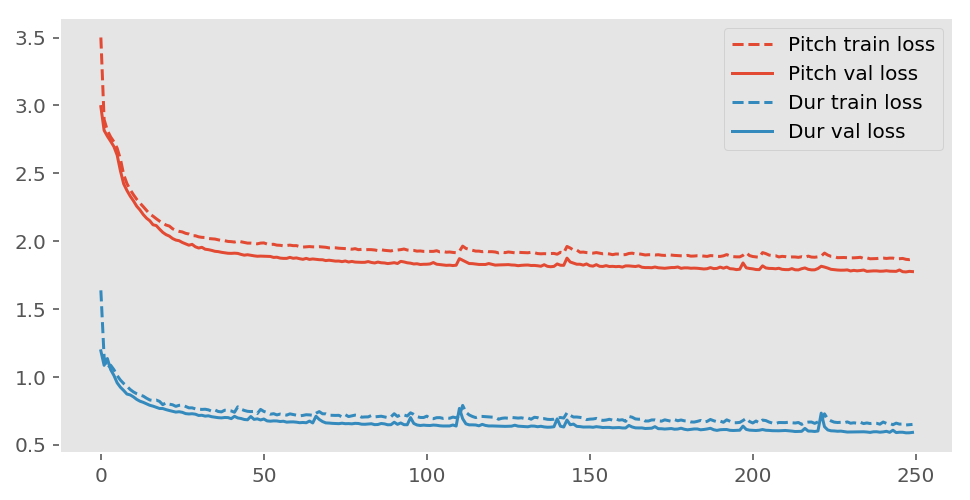

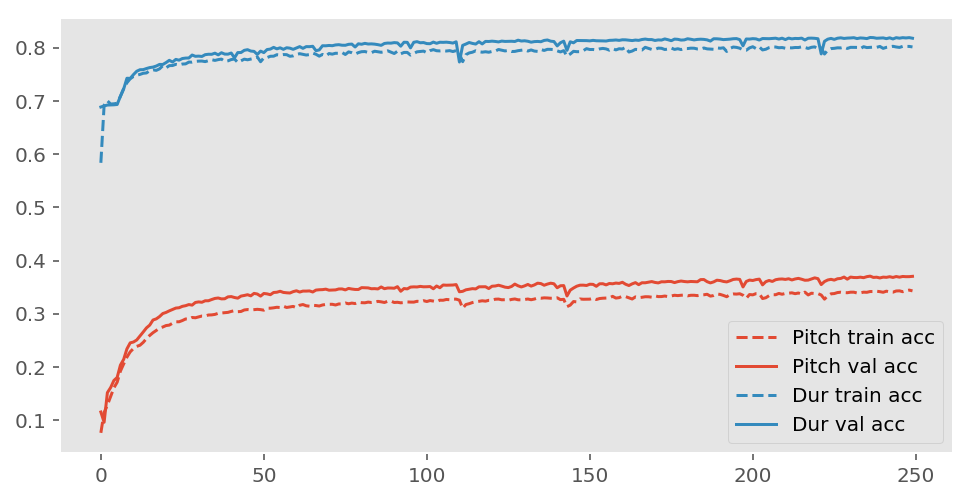

In [31]:
plotLearningCurves(history_RNN)

#### With GRU

In [43]:
GRUmodel = buildModel(dictionaries, 
                      batch_length=batch_length-1,
                      activation='GRU')
GRUmodel.summary()

history_GRU = GRUmodel.fit(x_train, y_train, epochs=250, validation_split = 0.2, verbose=2, batch_size=256)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 397, 17)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 397, 53)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 397, 17)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 397, 53)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

Epoch 30/250
 - 53s - loss: 2.6683 - YT_loss: 0.7022 - YP_loss: 1.9661 - YT_acc: 0.7857 - YP_acc: 0.3143 - val_loss: 2.5663 - val_YT_loss: 0.6712 - val_YP_loss: 1.8950 - val_YT_acc: 0.7964 - val_YP_acc: 0.3348
Epoch 31/250
 - 53s - loss: 2.6587 - YT_loss: 0.7008 - YP_loss: 1.9579 - YT_acc: 0.7861 - YP_acc: 0.3158 - val_loss: 2.5579 - val_YT_loss: 0.6668 - val_YP_loss: 1.8910 - val_YT_acc: 0.7986 - val_YP_acc: 0.3368
Epoch 32/250
 - 53s - loss: 2.6484 - YT_loss: 0.6912 - YP_loss: 1.9572 - YT_acc: 0.7898 - YP_acc: 0.3175 - val_loss: 2.5515 - val_YT_loss: 0.6655 - val_YP_loss: 1.8860 - val_YT_acc: 0.7979 - val_YP_acc: 0.3364
Epoch 33/250
 - 53s - loss: 2.6423 - YT_loss: 0.6909 - YP_loss: 1.9514 - YT_acc: 0.7890 - YP_acc: 0.3192 - val_loss: 2.5443 - val_YT_loss: 0.6619 - val_YP_loss: 1.8824 - val_YT_acc: 0.8000 - val_YP_acc: 0.3372
Epoch 34/250
 - 54s - loss: 2.6326 - YT_loss: 0.6849 - YP_loss: 1.9477 - YT_acc: 0.7915 - YP_acc: 0.3202 - val_loss: 2.5398 - val_YT_loss: 0.6615 - val_YP_loss:

 - 61s - loss: 2.4773 - YT_loss: 0.6290 - YP_loss: 1.8483 - YT_acc: 0.8061 - YP_acc: 0.3537 - val_loss: 2.3909 - val_YT_loss: 0.6065 - val_YP_loss: 1.7844 - val_YT_acc: 0.8166 - val_YP_acc: 0.3712
Epoch 70/250
 - 65s - loss: 2.4773 - YT_loss: 0.6310 - YP_loss: 1.8463 - YT_acc: 0.8061 - YP_acc: 0.3538 - val_loss: 2.3887 - val_YT_loss: 0.6053 - val_YP_loss: 1.7834 - val_YT_acc: 0.8157 - val_YP_acc: 0.3719
Epoch 71/250
 - 72s - loss: 2.4703 - YT_loss: 0.6265 - YP_loss: 1.8438 - YT_acc: 0.8067 - YP_acc: 0.3548 - val_loss: 2.3832 - val_YT_loss: 0.6028 - val_YP_loss: 1.7804 - val_YT_acc: 0.8170 - val_YP_acc: 0.3728
Epoch 72/250
 - 62s - loss: 2.4672 - YT_loss: 0.6247 - YP_loss: 1.8425 - YT_acc: 0.8073 - YP_acc: 0.3566 - val_loss: 2.3817 - val_YT_loss: 0.6013 - val_YP_loss: 1.7804 - val_YT_acc: 0.8174 - val_YP_acc: 0.3718
Epoch 73/250
 - 61s - loss: 2.4665 - YT_loss: 0.6258 - YP_loss: 1.8407 - YT_acc: 0.8063 - YP_acc: 0.3554 - val_loss: 2.3781 - val_YT_loss: 0.6010 - val_YP_loss: 1.7771 - val

 - 62s - loss: 2.3737 - YT_loss: 0.5898 - YP_loss: 1.7839 - YT_acc: 0.8138 - YP_acc: 0.3761 - val_loss: 2.2942 - val_YT_loss: 0.5668 - val_YP_loss: 1.7275 - val_YT_acc: 0.8213 - val_YP_acc: 0.3918
Epoch 109/250
 - 59s - loss: 2.3717 - YT_loss: 0.5889 - YP_loss: 1.7827 - YT_acc: 0.8146 - YP_acc: 0.3755 - val_loss: 2.2942 - val_YT_loss: 0.5680 - val_YP_loss: 1.7262 - val_YT_acc: 0.8213 - val_YP_acc: 0.3914
Epoch 110/250
 - 61s - loss: 2.3691 - YT_loss: 0.5887 - YP_loss: 1.7804 - YT_acc: 0.8146 - YP_acc: 0.3765 - val_loss: 2.2903 - val_YT_loss: 0.5651 - val_YP_loss: 1.7253 - val_YT_acc: 0.8217 - val_YP_acc: 0.3917
Epoch 111/250
 - 60s - loss: 2.3695 - YT_loss: 0.5895 - YP_loss: 1.7800 - YT_acc: 0.8135 - YP_acc: 0.3764 - val_loss: 2.2895 - val_YT_loss: 0.5636 - val_YP_loss: 1.7259 - val_YT_acc: 0.8220 - val_YP_acc: 0.3903
Epoch 112/250
 - 56s - loss: 2.3616 - YT_loss: 0.5826 - YP_loss: 1.7789 - YT_acc: 0.8159 - YP_acc: 0.3775 - val_loss: 2.2850 - val_YT_loss: 0.5628 - val_YP_loss: 1.7221 -

Epoch 147/250
 - 55s - loss: 2.2817 - YT_loss: 0.5465 - YP_loss: 1.7352 - YT_acc: 0.8215 - YP_acc: 0.3929 - val_loss: 2.2085 - val_YT_loss: 0.5231 - val_YP_loss: 1.6854 - val_YT_acc: 0.8276 - val_YP_acc: 0.4058
Epoch 148/250
 - 55s - loss: 2.2793 - YT_loss: 0.5440 - YP_loss: 1.7353 - YT_acc: 0.8227 - YP_acc: 0.3926 - val_loss: 2.2032 - val_YT_loss: 0.5214 - val_YP_loss: 1.6817 - val_YT_acc: 0.8281 - val_YP_acc: 0.4073
Epoch 149/250
 - 55s - loss: 2.2728 - YT_loss: 0.5426 - YP_loss: 1.7302 - YT_acc: 0.8219 - YP_acc: 0.3946 - val_loss: 2.2021 - val_YT_loss: 0.5203 - val_YP_loss: 1.6817 - val_YT_acc: 0.8288 - val_YP_acc: 0.4087
Epoch 150/250
 - 54s - loss: 2.2739 - YT_loss: 0.5443 - YP_loss: 1.7296 - YT_acc: 0.8226 - YP_acc: 0.3951 - val_loss: 2.1990 - val_YT_loss: 0.5196 - val_YP_loss: 1.6794 - val_YT_acc: 0.8284 - val_YP_acc: 0.4090
Epoch 151/250
 - 56s - loss: 2.2721 - YT_loss: 0.5432 - YP_loss: 1.7289 - YT_acc: 0.8220 - YP_acc: 0.3960 - val_loss: 2.2005 - val_YT_loss: 0.5203 - val_YP_

Epoch 186/250
 - 56s - loss: 2.2176 - YT_loss: 0.5219 - YP_loss: 1.6957 - YT_acc: 0.8258 - YP_acc: 0.4064 - val_loss: 2.1511 - val_YT_loss: 0.5002 - val_YP_loss: 1.6510 - val_YT_acc: 0.8315 - val_YP_acc: 0.4195
Epoch 187/250
 - 55s - loss: 2.2206 - YT_loss: 0.5234 - YP_loss: 1.6972 - YT_acc: 0.8246 - YP_acc: 0.4063 - val_loss: 2.1505 - val_YT_loss: 0.5000 - val_YP_loss: 1.6505 - val_YT_acc: 0.8317 - val_YP_acc: 0.4194
Epoch 188/250
 - 56s - loss: 2.2146 - YT_loss: 0.5209 - YP_loss: 1.6937 - YT_acc: 0.8256 - YP_acc: 0.4077 - val_loss: 2.1470 - val_YT_loss: 0.4980 - val_YP_loss: 1.6489 - val_YT_acc: 0.8313 - val_YP_acc: 0.4204
Epoch 189/250
 - 57s - loss: 2.2108 - YT_loss: 0.5176 - YP_loss: 1.6933 - YT_acc: 0.8268 - YP_acc: 0.4075 - val_loss: 2.1464 - val_YT_loss: 0.4990 - val_YP_loss: 1.6474 - val_YT_acc: 0.8319 - val_YP_acc: 0.4208
Epoch 190/250
 - 55s - loss: 2.2076 - YT_loss: 0.5174 - YP_loss: 1.6902 - YT_acc: 0.8259 - YP_acc: 0.4078 - val_loss: 2.1441 - val_YT_loss: 0.4975 - val_YP_

Epoch 225/250
 - 68s - loss: 2.1703 - YT_loss: 0.5088 - YP_loss: 1.6616 - YT_acc: 0.8271 - YP_acc: 0.4176 - val_loss: 2.1120 - val_YT_loss: 0.4896 - val_YP_loss: 1.6225 - val_YT_acc: 0.8322 - val_YP_acc: 0.4283
Epoch 226/250
 - 65s - loss: 2.1619 - YT_loss: 0.5027 - YP_loss: 1.6592 - YT_acc: 0.8288 - YP_acc: 0.4190 - val_loss: 2.1112 - val_YT_loss: 0.4884 - val_YP_loss: 1.6229 - val_YT_acc: 0.8327 - val_YP_acc: 0.4291
Epoch 227/250
 - 64s - loss: 2.1641 - YT_loss: 0.5057 - YP_loss: 1.6584 - YT_acc: 0.8268 - YP_acc: 0.4200 - val_loss: 2.1096 - val_YT_loss: 0.4886 - val_YP_loss: 1.6210 - val_YT_acc: 0.8328 - val_YP_acc: 0.4308
Epoch 228/250
 - 61s - loss: 2.1616 - YT_loss: 0.5041 - YP_loss: 1.6575 - YT_acc: 0.8284 - YP_acc: 0.4195 - val_loss: 2.1079 - val_YT_loss: 0.4882 - val_YP_loss: 1.6197 - val_YT_acc: 0.8323 - val_YP_acc: 0.4311
Epoch 229/250
 - 62s - loss: 2.1607 - YT_loss: 0.5047 - YP_loss: 1.6559 - YT_acc: 0.8278 - YP_acc: 0.4202 - val_loss: 2.1061 - val_YT_loss: 0.4878 - val_YP_

In [44]:
GRUmodel.save('GRUmodel.h5')
f = open("history_GRU.pkl","wb")
pickle.dump(history_GRU.history,f)
f.close()

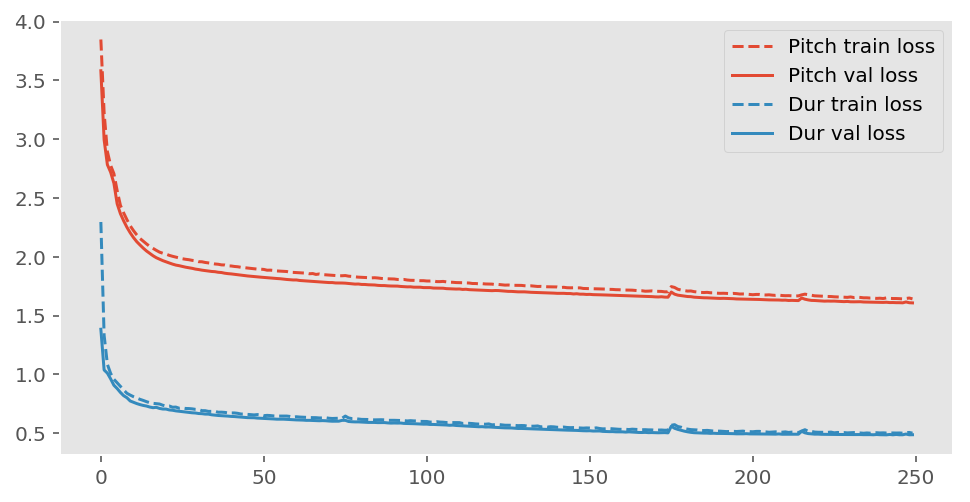

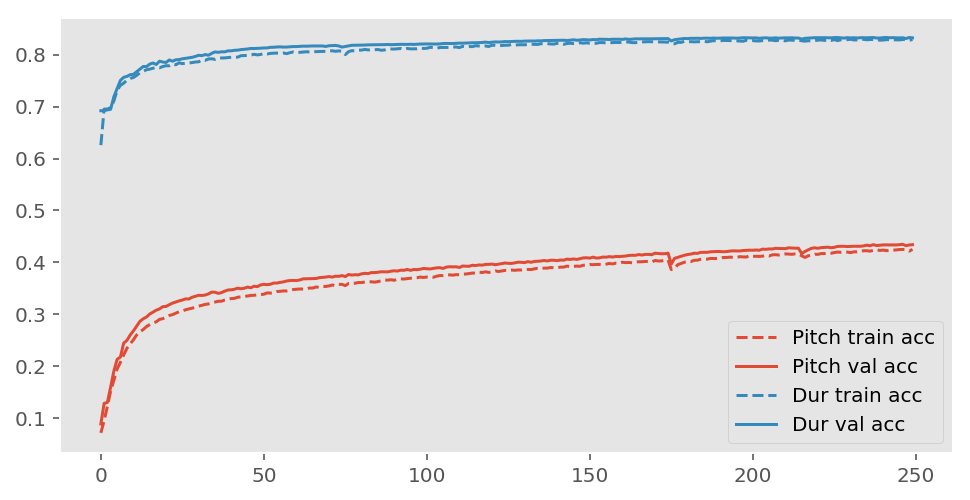

In [45]:
plotLearningCurves(history_GRU)

### SimpleRNN VS GRU

In [29]:
file = open("history_GRU.pkl",'rb')
history_GRU = pickle.load(file)
file.close()

file = open("history_RNN.pkl",'rb')
history_RNN = pickle.load(file)
file.close()

### Learning curve for the loss

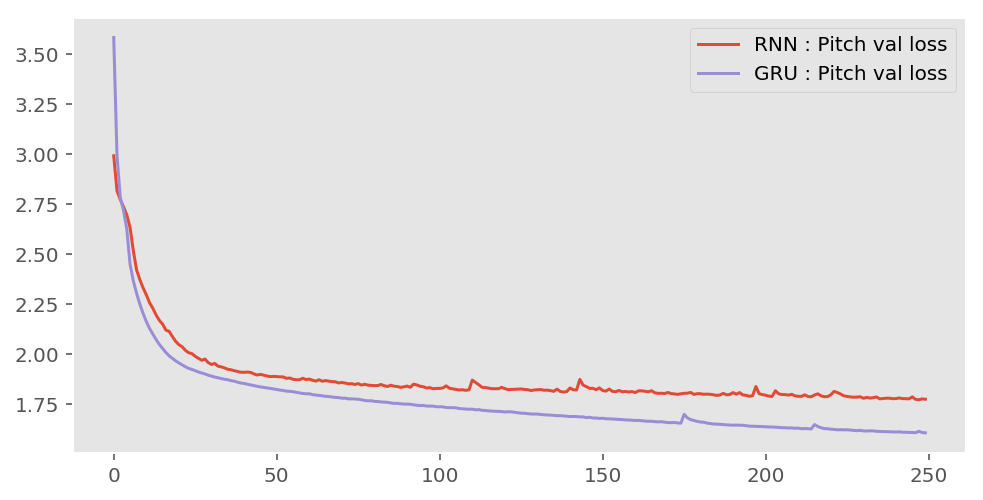

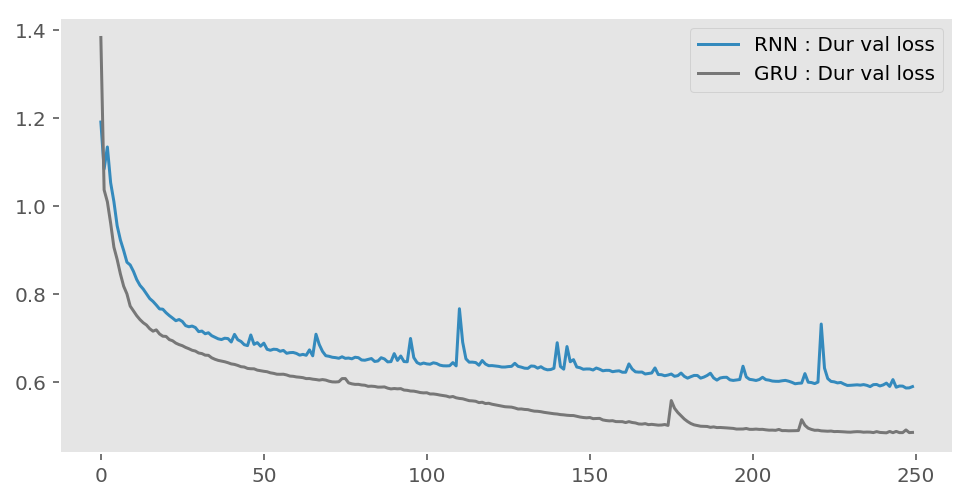

In [34]:
plotLearningCurves_loss(history_RNN, history_GRU)

### Learning curve for the accuracy

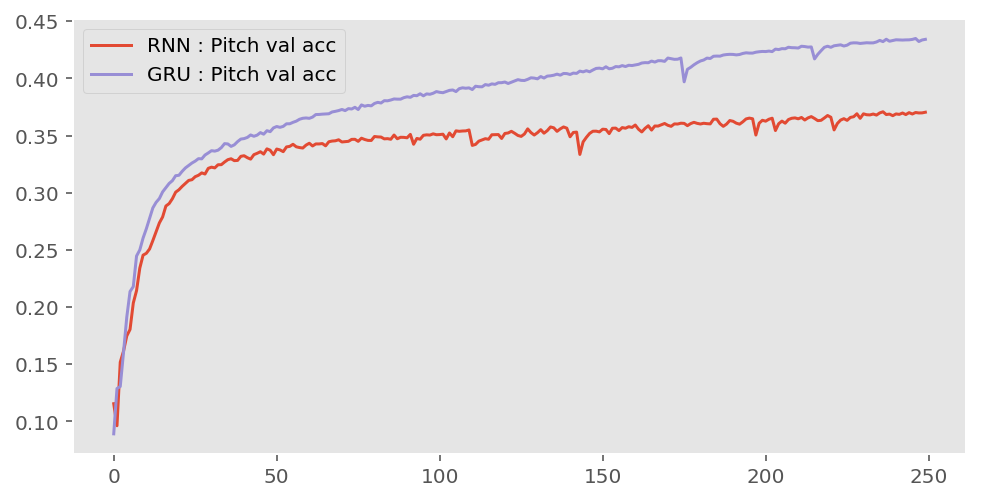

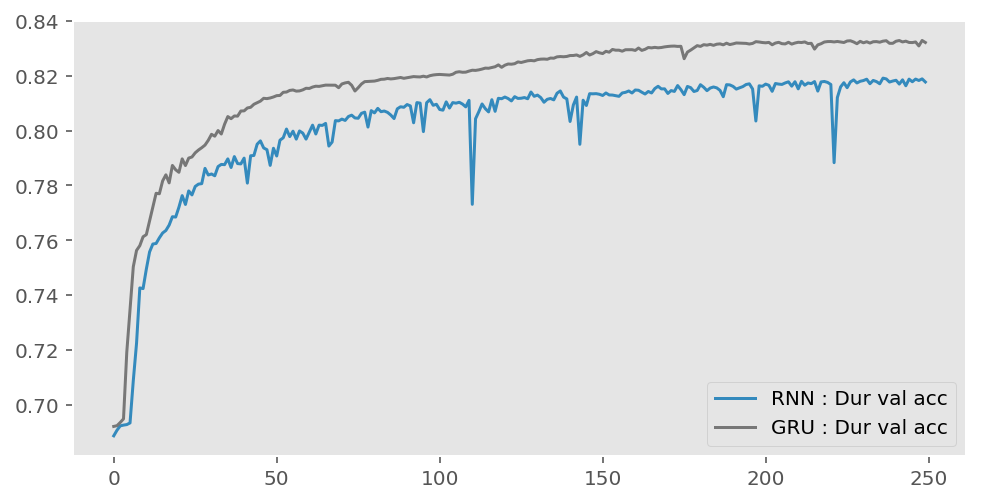

In [35]:
plotLearningCurves_acc(history_RNN, history_GRU)

**Question**: What are the best prediction accuracies you obtained? With which model?
    
**Answer**: 83% for duration and 43% for pitch with GRU

**Question**: In a few sentences, comment on the plot comparing learning curves for the two activation function.
    
**Answer**: we can see that GRU has better loss and accuracy for both pitch and duration. we can see that for the the validation accuracy duration it pratically converge for both model, on the other hand for the pitch validation accuracy we can see that   GRU has not yet converged.



## Exercise 6: Visualizing the model
### Description

1. Using the model.predict and plotMelody functions, show the outputs of your best model when fed with 4 randomly selected melodies. Report the prediction accuracies as well.
2. For the same melodies, plot the hidden state evolution accross time steps. Construct a 2 dimensional matrix with the first dimension being time and the second the concatenation of all hidden unit activations and plot it using the provided `plotMelody` function. To get the hidden states of your network, you can modify the `buildModel` function so that you have another computation graph (another model with the same layers, but the output layer) returning you the hidden states. However, other approaches are equally valid.  
3. For each hidden unit $i$ and accross the entire dataset, compute the average absolute change in activation $\Delta A_i$. Be careful not to take masked timesteps into account. Plot the histogram (50 bins) of this average for the RNN and GRU models on the same figure.

### Solution

#### Restore models

In [39]:
RNNmodel = load_model('RNNmodel.h5')
GRUmodel = load_model('GRUmodel.h5')

### 1

In [83]:
# choose the best model
model = GRUmodel

In [84]:
NUM_MELODY = 4

X = {}
X['T'] = np.zeros((NUM_MELODY, batch_length-1, len(dictionaries['T'])))
X['P'] = np.zeros((NUM_MELODY, batch_length-1, len(dictionaries['P'])))

Y = {}
Y['T'] = np.zeros((NUM_MELODY, batch_length-1, len(dictionaries['T'])))
Y['P'] = np.zeros((NUM_MELODY, batch_length-1, len(dictionaries['P'])))

for i, label in enumerate(np.random.choice(list(dataset.keys()), NUM_MELODY)):
    print(label)

    X['T'][i] += dataset[label]['T'][:-1]
    X['P'][i] += dataset[label]['P'][:-1]
    
    Y['T'][i] += dataset[label]['T'][1:]
    Y['P'][i] += dataset[label]['P'][1:]

x = [X['T'], X['P']]
y = [Y['T'], Y['P']]

PrT, PrP = model.predict(x)

sessiontune34972
sessiontune39827
sessiontune28467
sessiontune6039


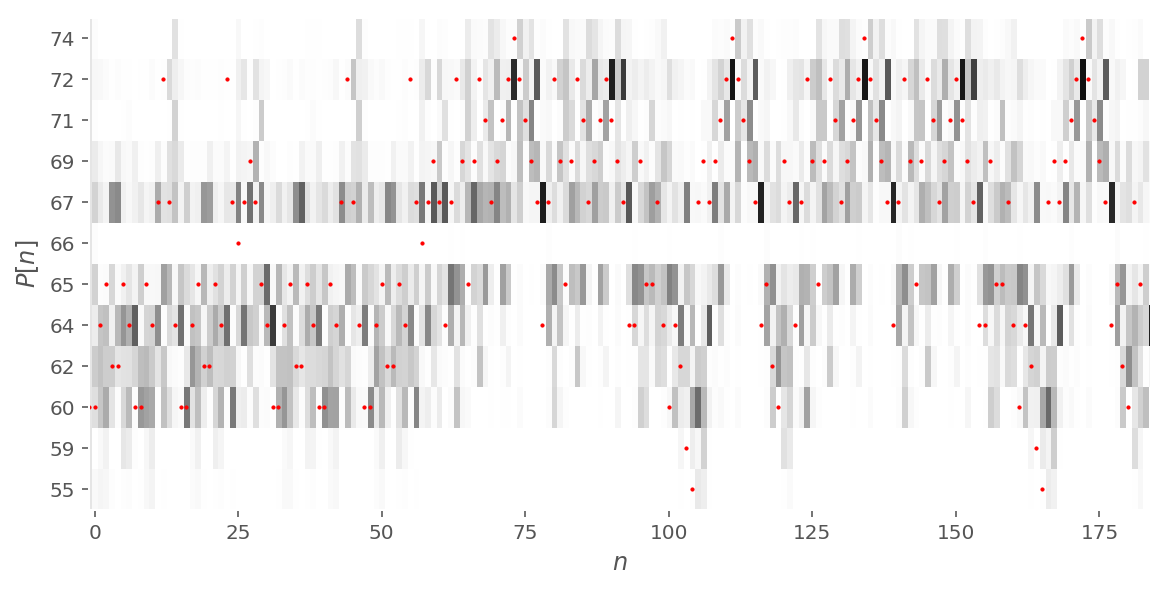

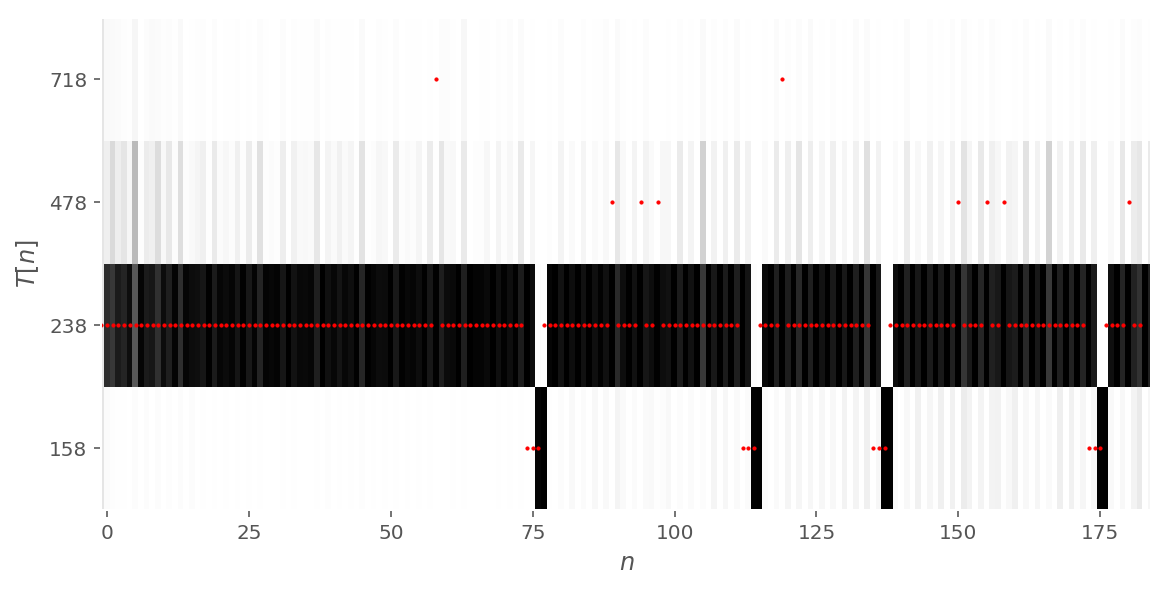

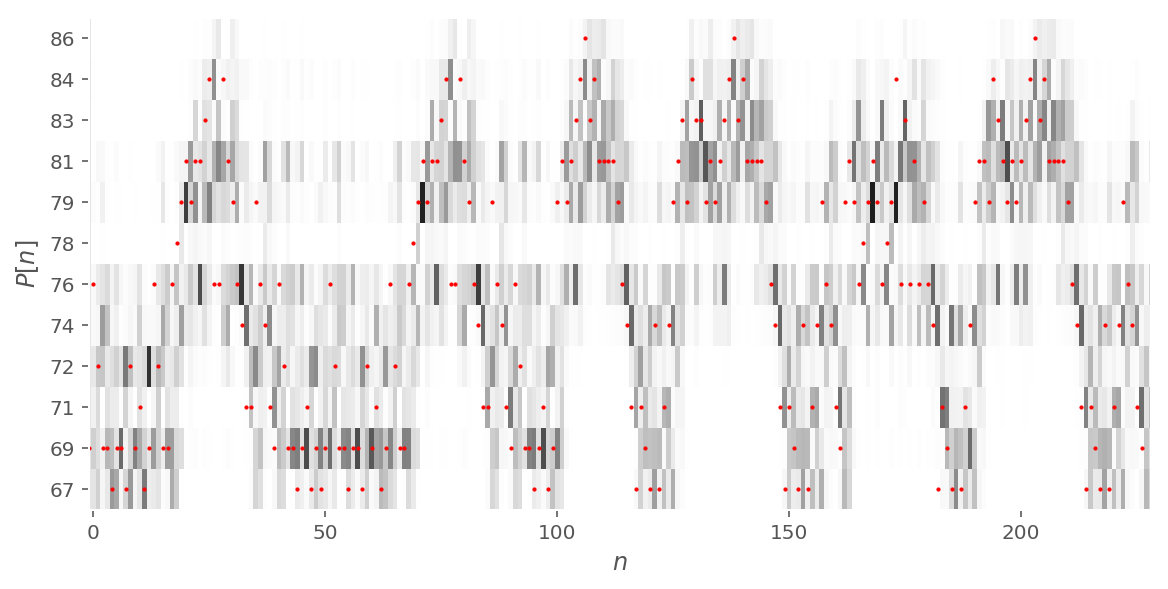

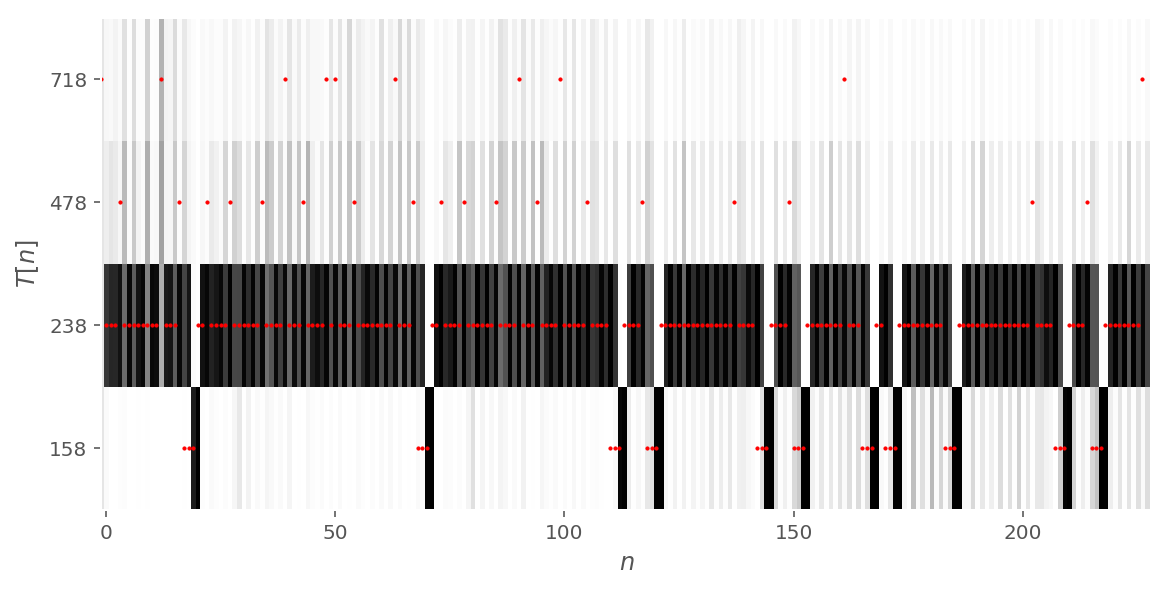

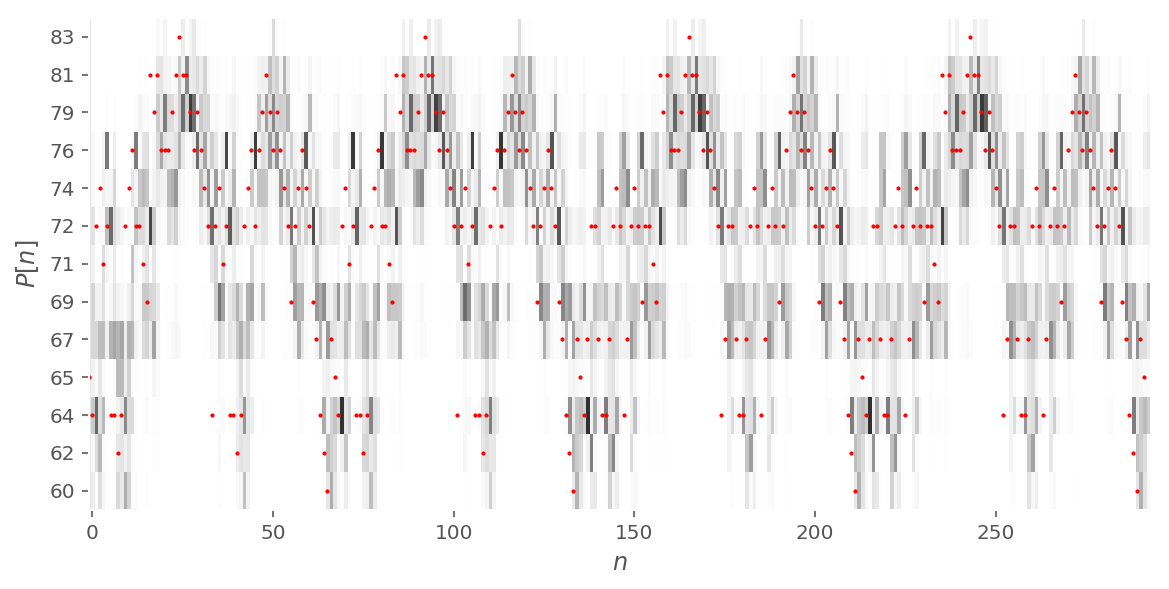

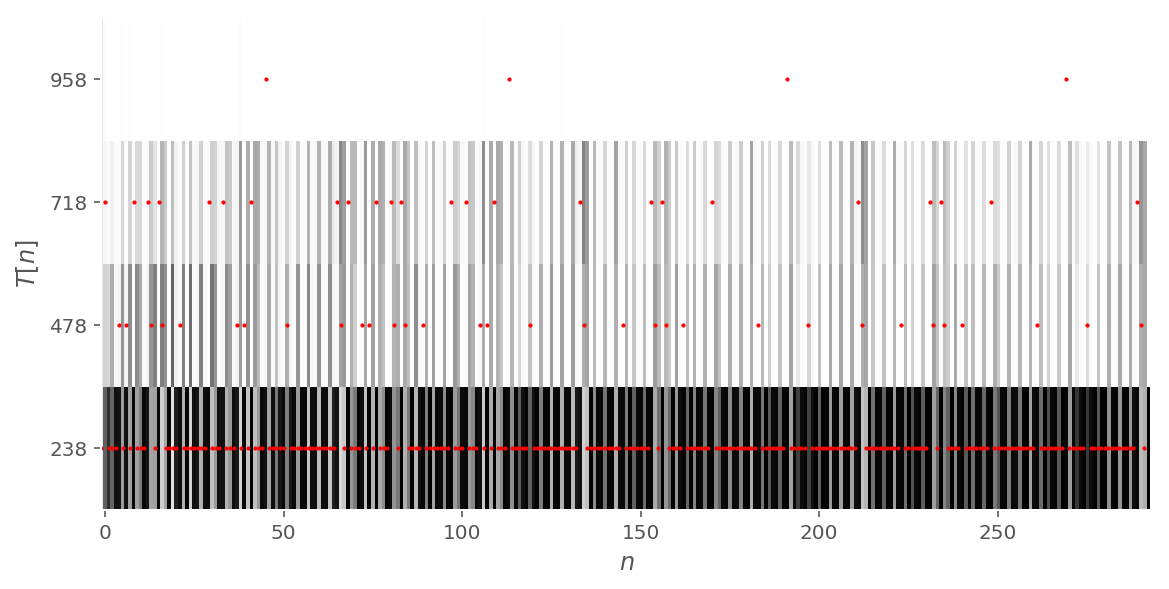

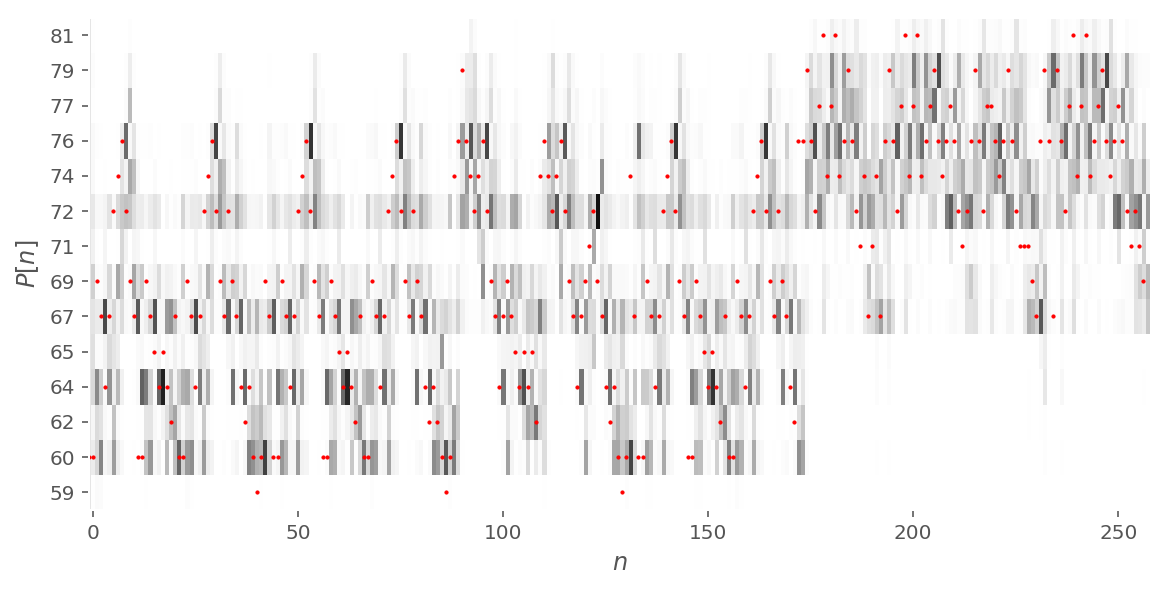

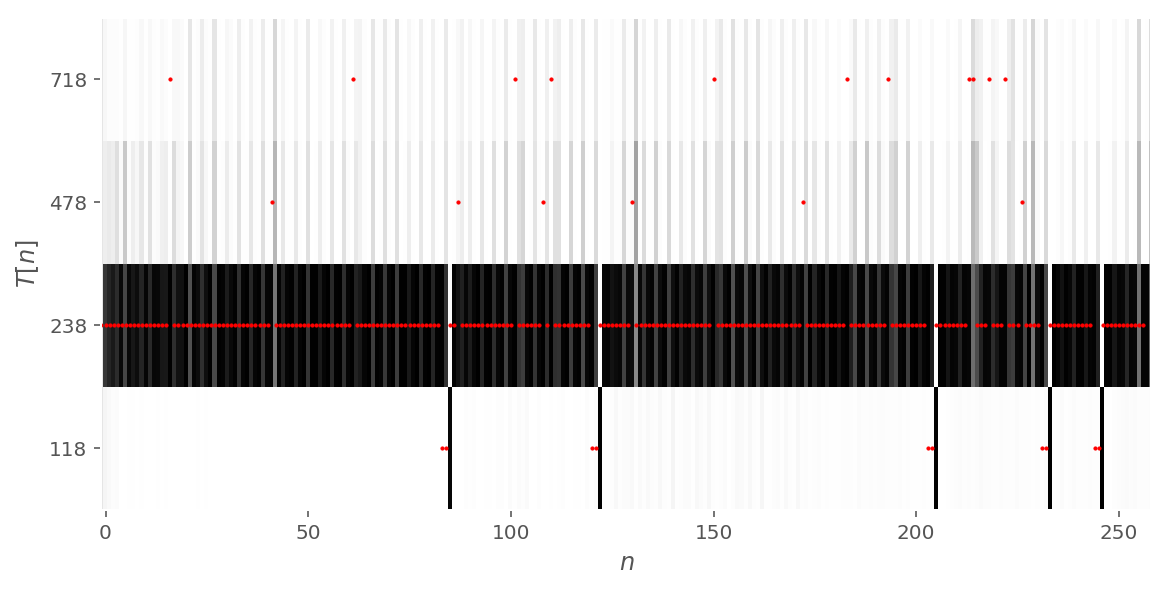

In [20]:
for i in range(0,NUM_MELODY):
    plotMelody(Y['P'][i], Y['T'][i], dictionaries_inv, PrP=PrP[i], PrT=PrT[i], H=None)

#### Accuracy

In [64]:
def length_melodies(x):
    length_melody = []
    for j in range(0, x.shape[0]):
        length_melody.append(np.where(x[j]==1)[0][-1]+1)
    return length_melody



In [162]:
length_melody = length_melodies(y[0])

In [164]:
pred_T = keras.utils.to_categorical(PrT.argmax(axis=-1), len(dictionaries['T']))
pred_P = keras.utils.to_categorical(PrP.argmax(axis=-1), len(dictionaries['P']))

In [100]:
def accuracy(pred, y, length_melody):
    acc = []
    for i in range(0, NUM_MELODY):
        count = 0
        err = pred[i]-y[i]
        for j in range(0, length_melody[i]) :
            if (not np.array_equal(pred[i][j], y[i][j])):
                count += 1
        acc.append(1-count/length_melody[i])
    return acc


In [101]:
print("Duration accuracy")
acc_T = accuracy(pred_T, y[0], length_melody)
for i, acc in enumerate(acc_T):
    print("melody ", i+1, ": {0:.0f}".format(acc*100), "%")

Duration accuracy
melody  1 : 93 %
melody  2 : 82 %
melody  3 : 80 %
melody  4 : 91 %


In [102]:
print("Pitch accuracy")
acc_P = accuracy(pred_P, y[1], length_melody)
for i, acc in enumerate(acc_P):
    print("melody ", i+1, ": {0:.0f}".format(acc*100), "%")

Pitch accuracy
melody  1 : 38 %
melody  2 : 49 %
melody  3 : 38 %
melody  4 : 44 %


### 2

For the same melodies, plot the hidden state evolution accross time steps.

#### for SimpleRNN

In [86]:
layer_name = 'simple_rnn_1'
intermediate_layer_model = Model(inputs=RNNmodel.input,
                                 outputs=RNNmodel.get_layer(layer_name).output)
h = intermediate_layer_model.predict(x)

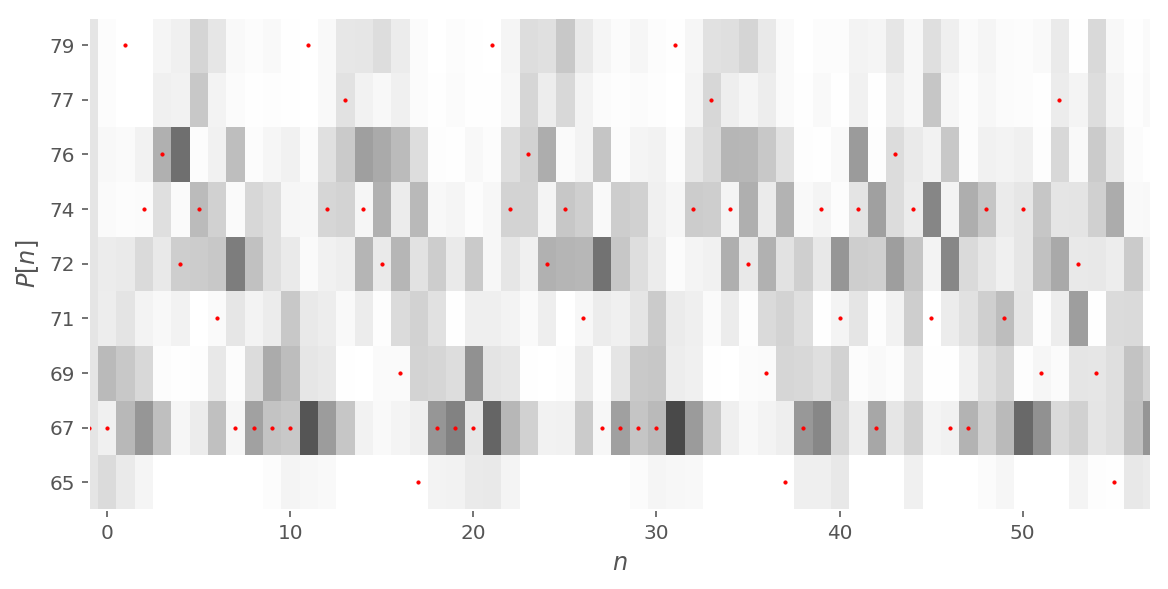

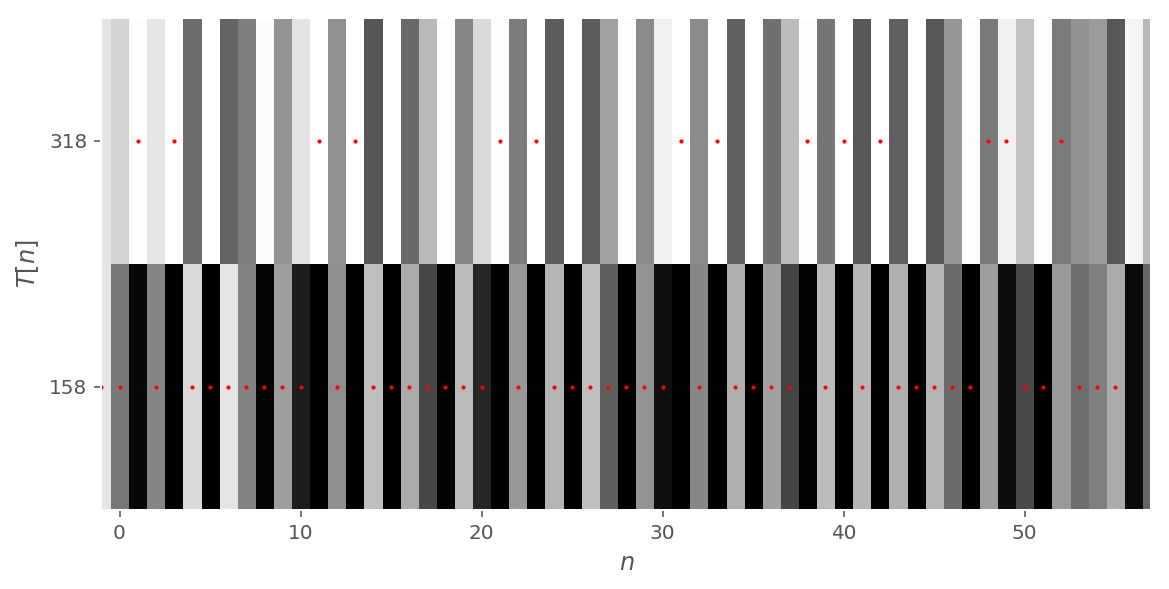

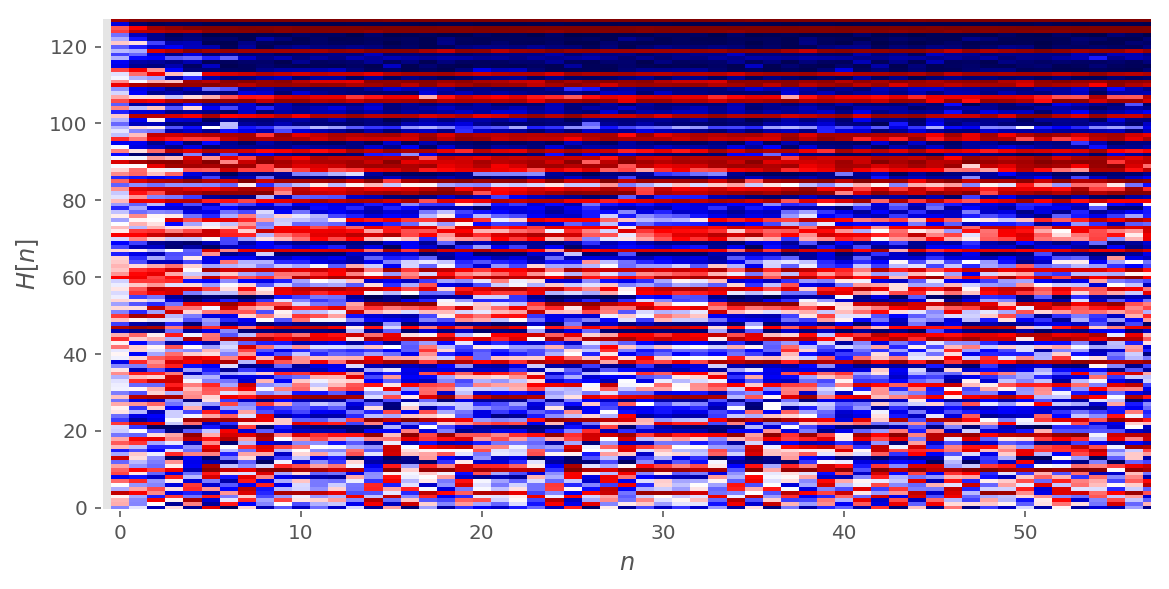

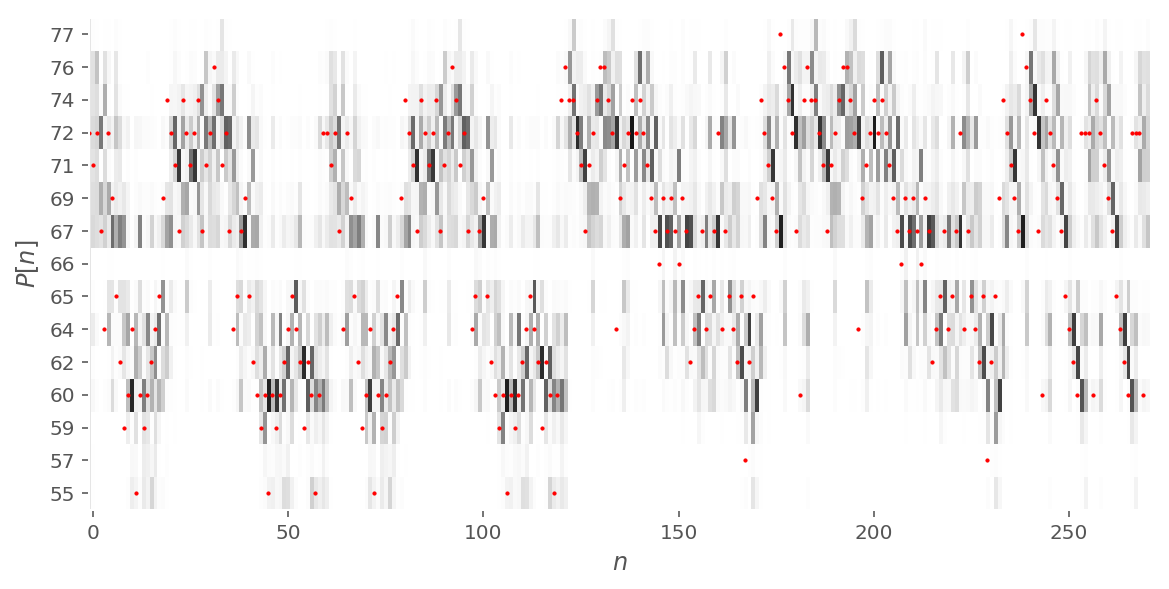

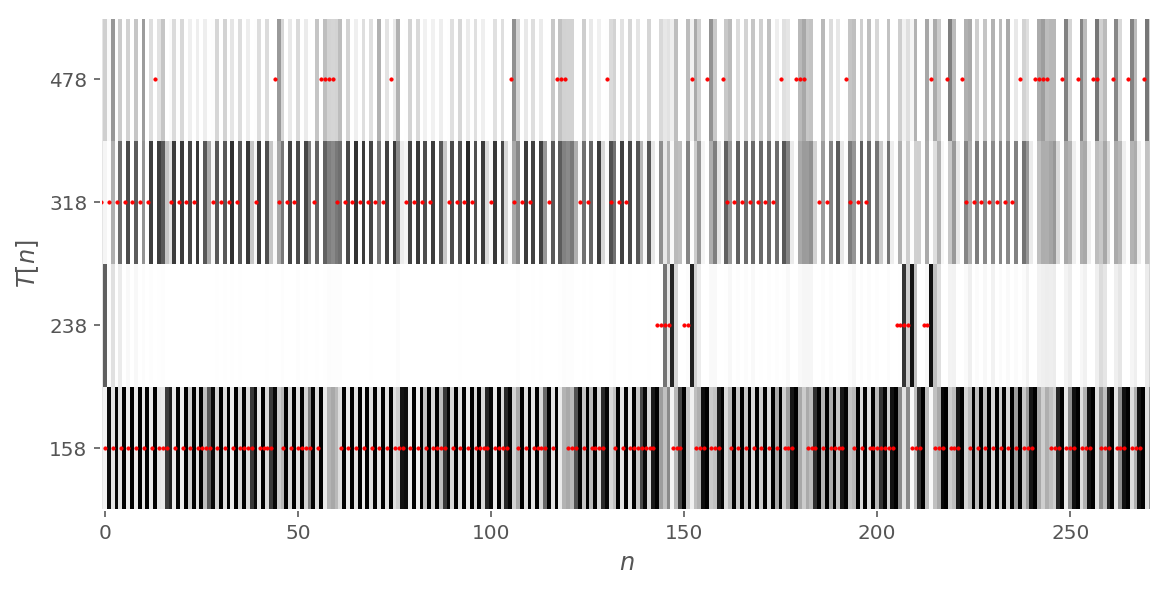

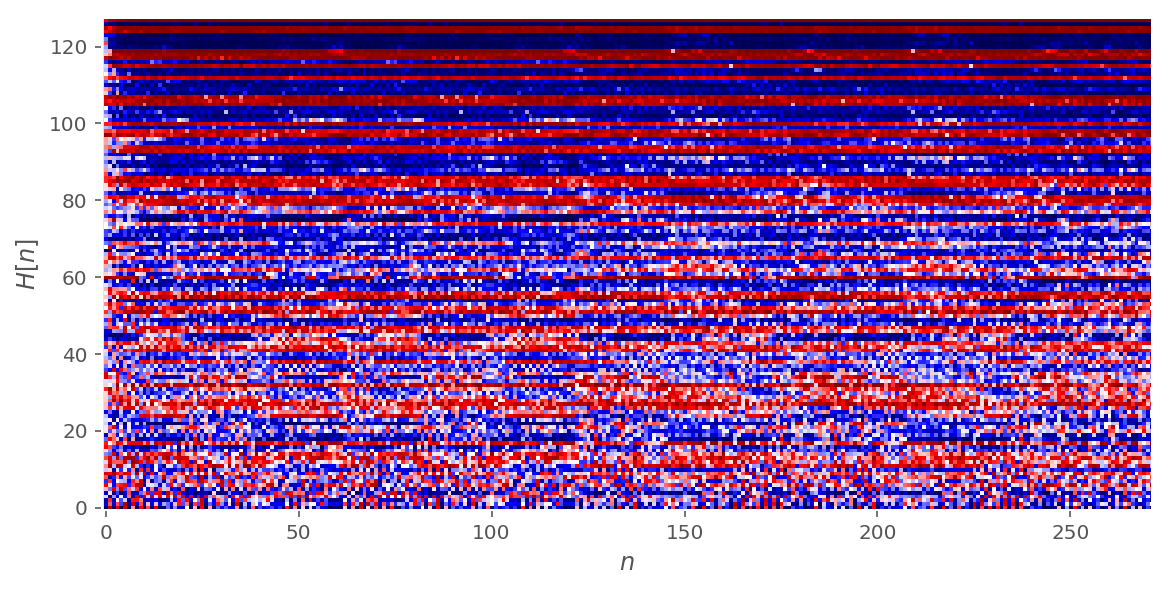

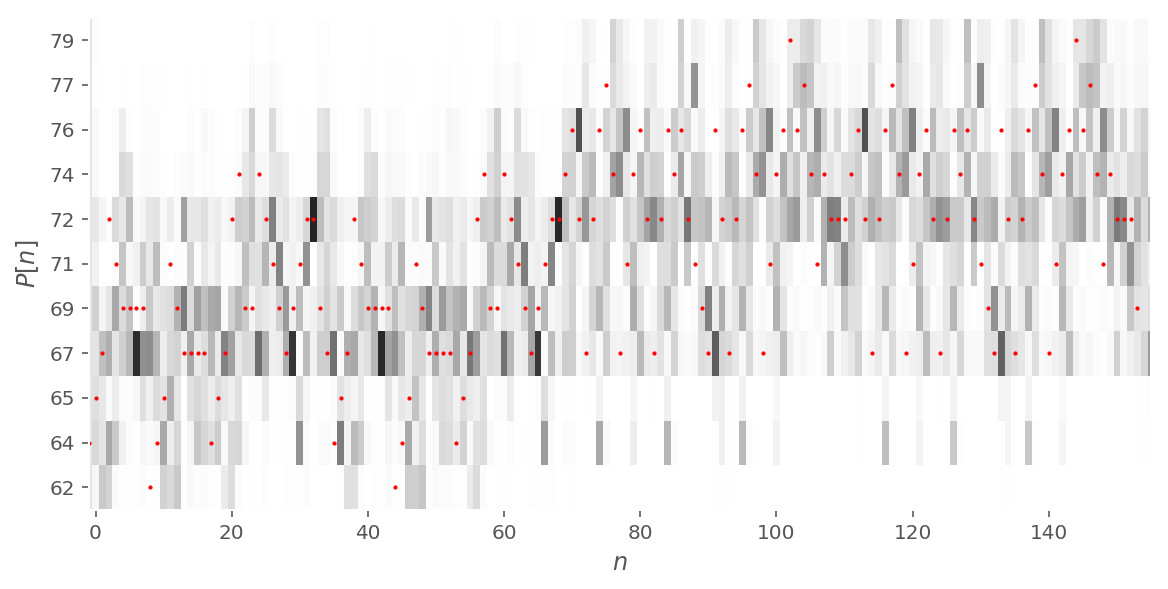

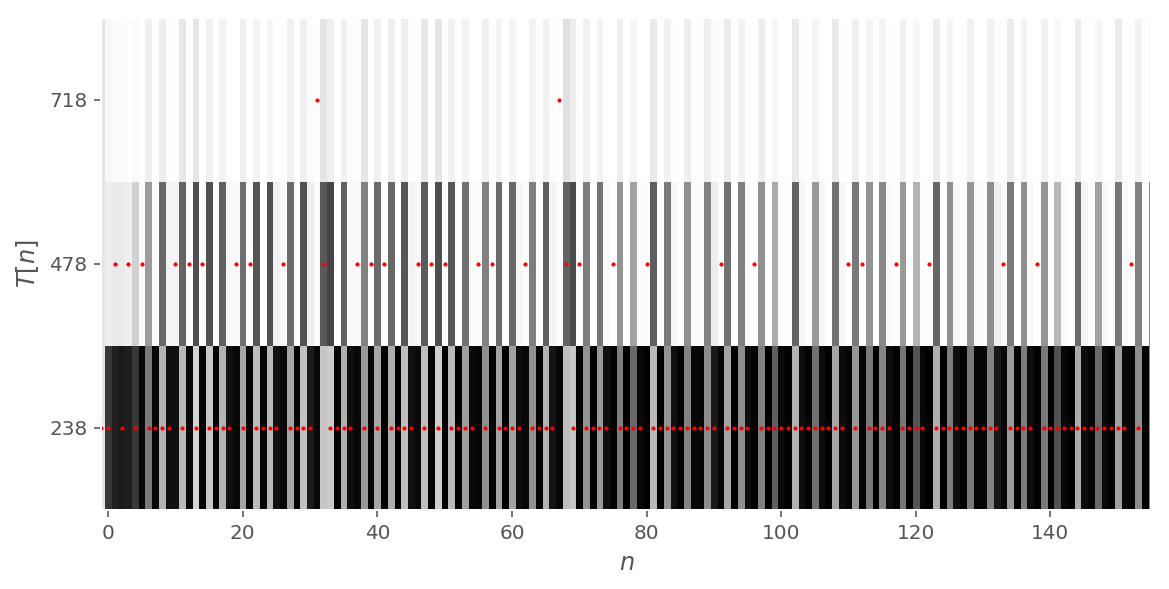

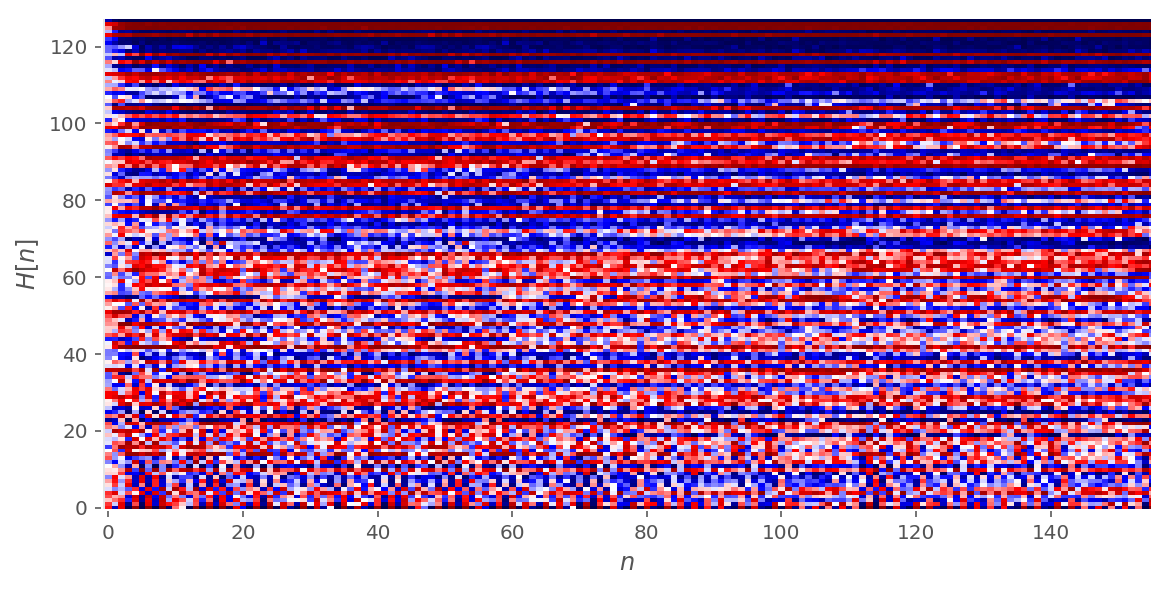

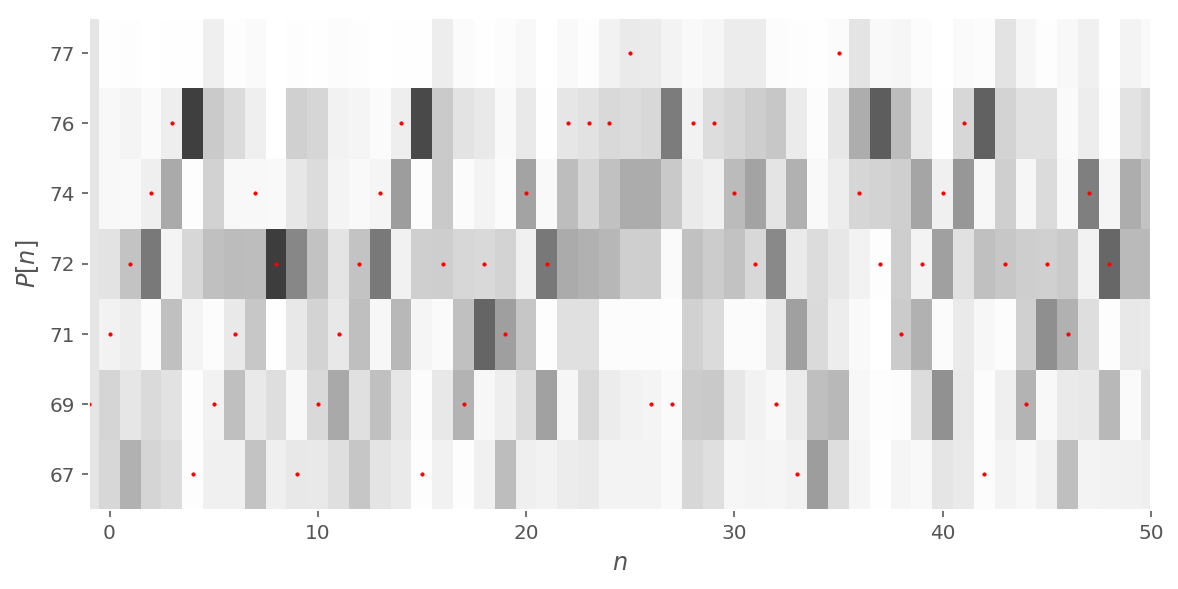

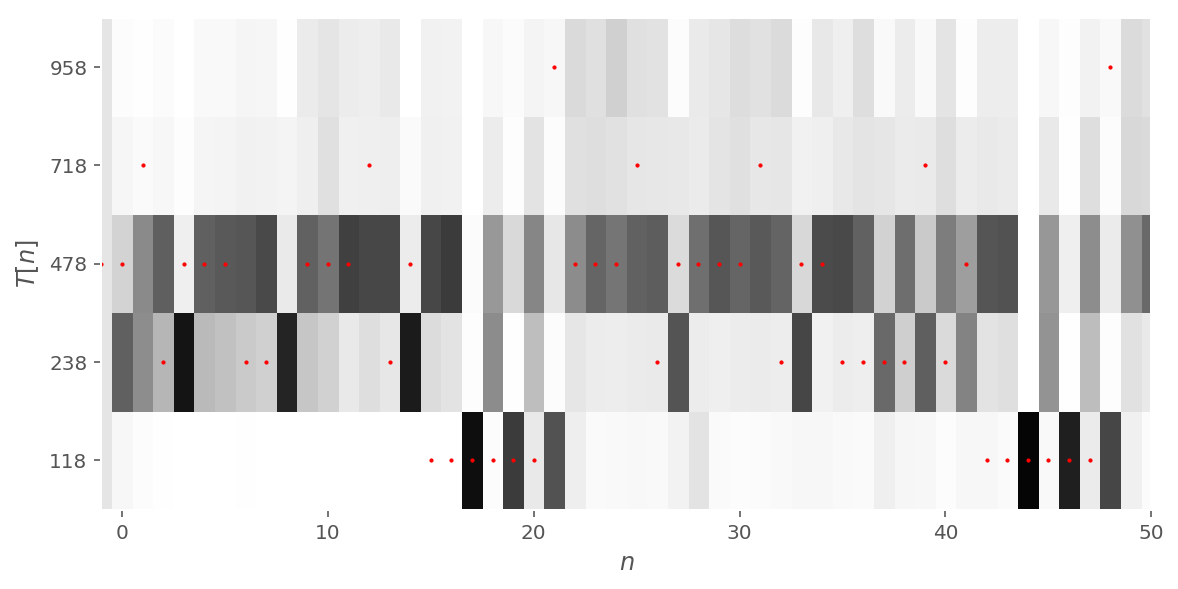

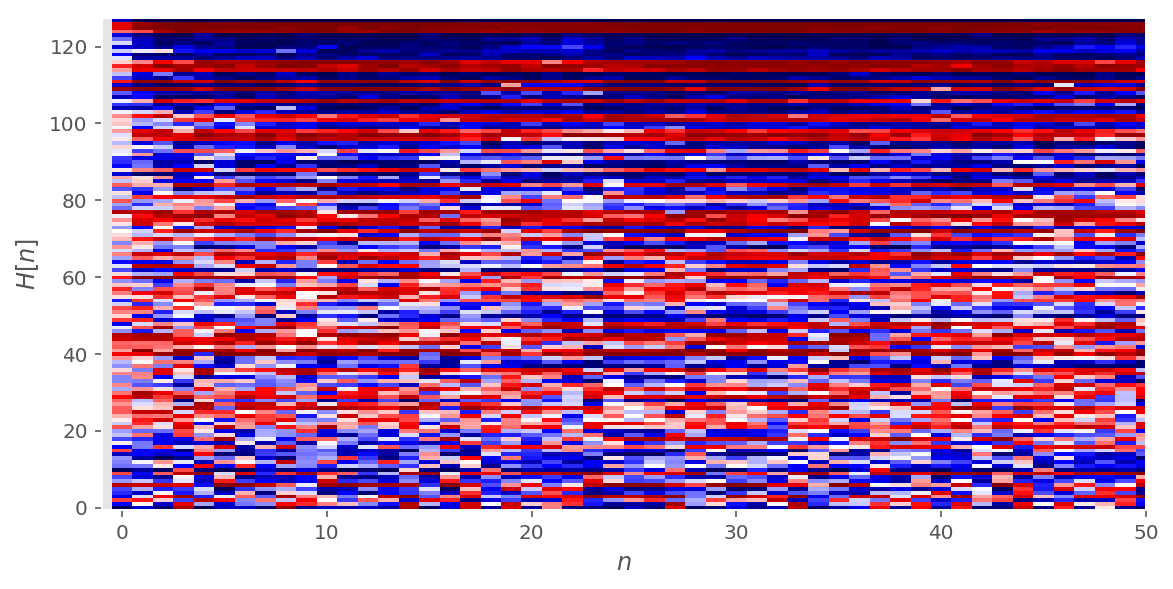

In [87]:
for i in range(0,NUM_MELODY):
    plotMelody(Y['P'][i], Y['T'][i], dictionaries_inv, PrP=PrP[i], PrT=PrT[i], H=h[i])

#### for GRU

In [88]:
layer_name = 'gru_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
h = intermediate_layer_model.predict(x)

In [89]:
h.shape

(4, 397, 128)

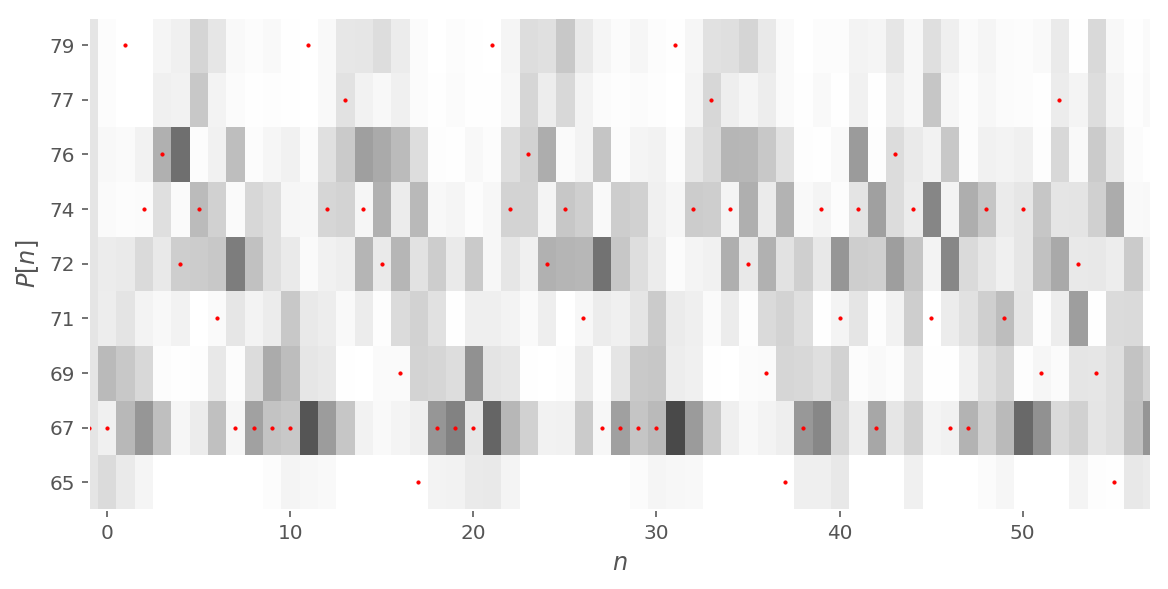

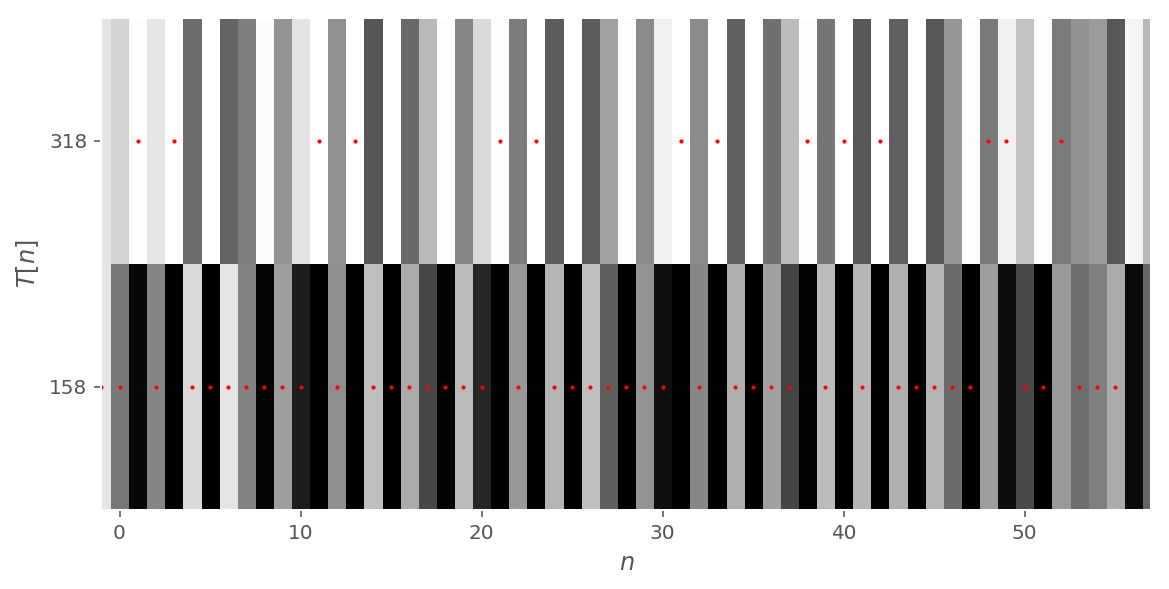

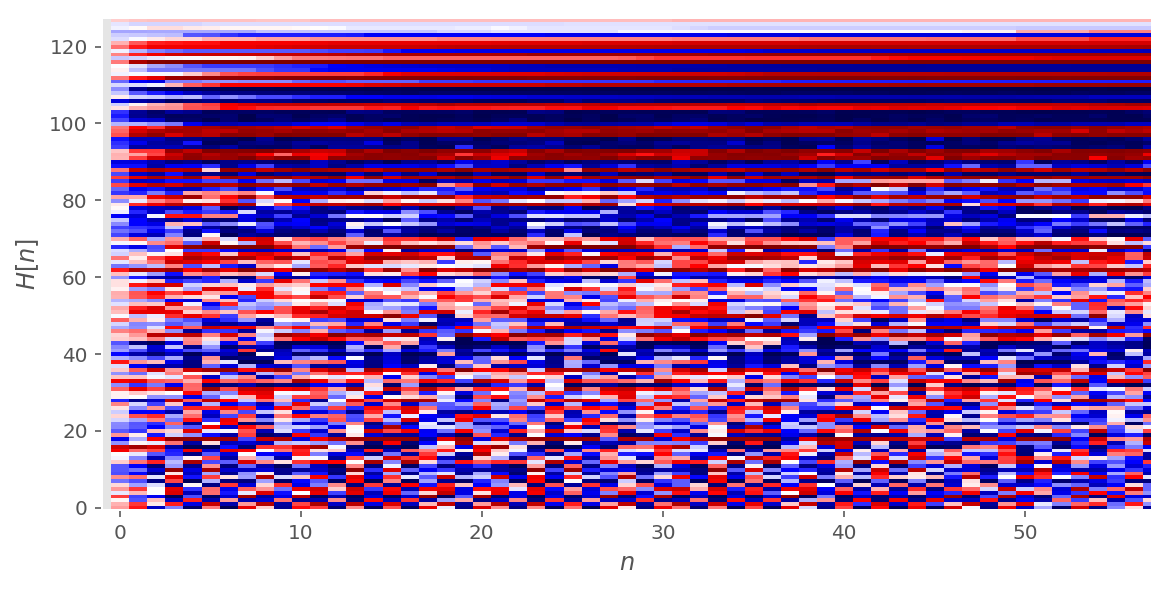

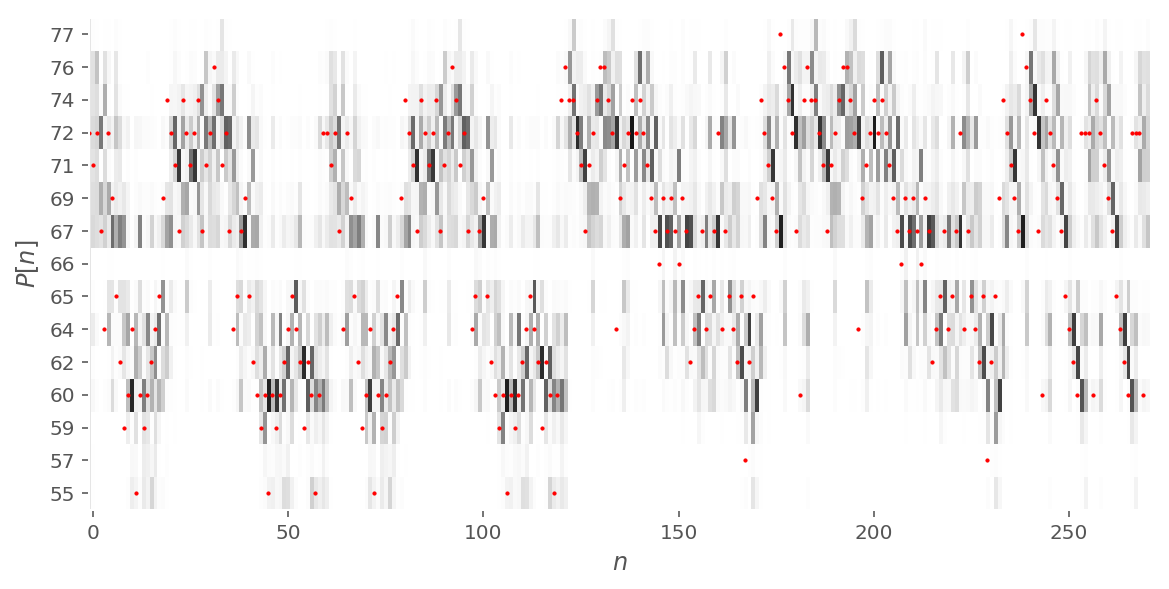

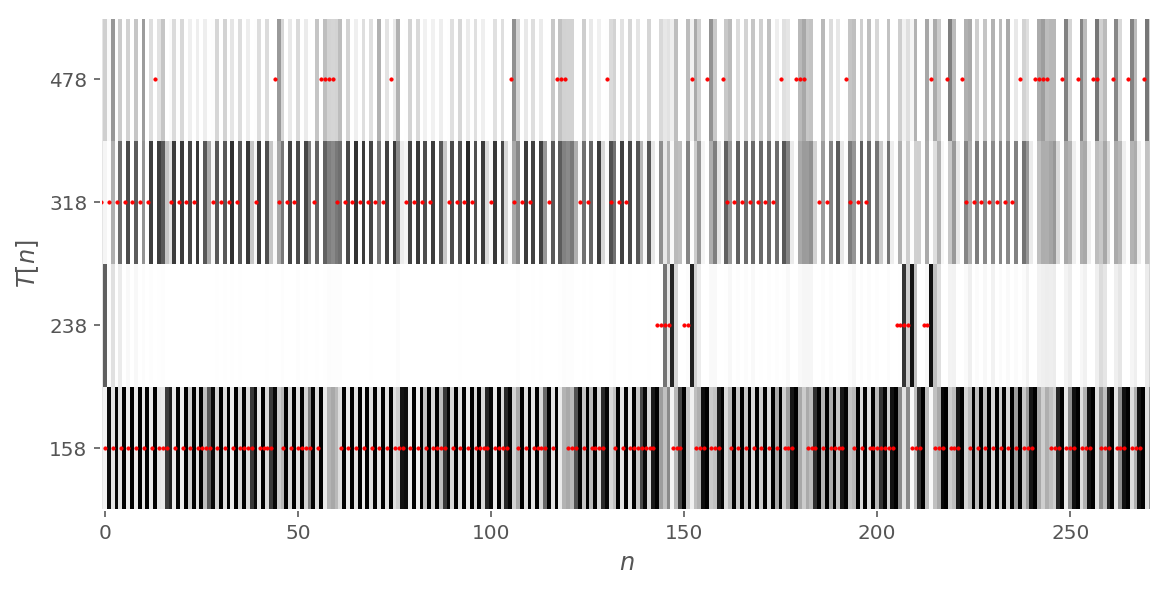

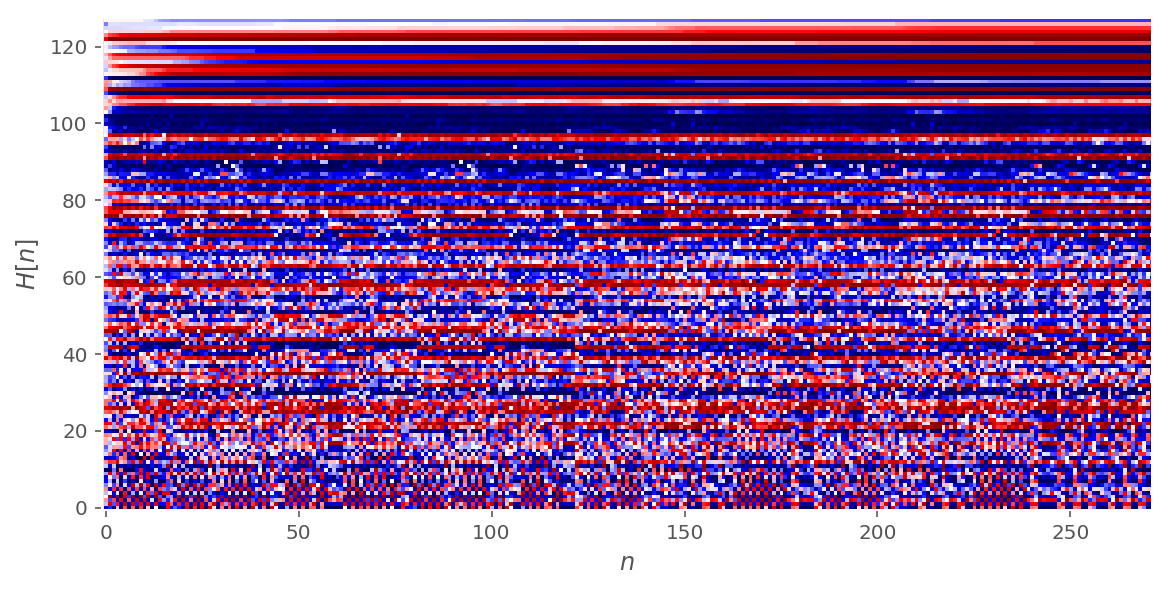

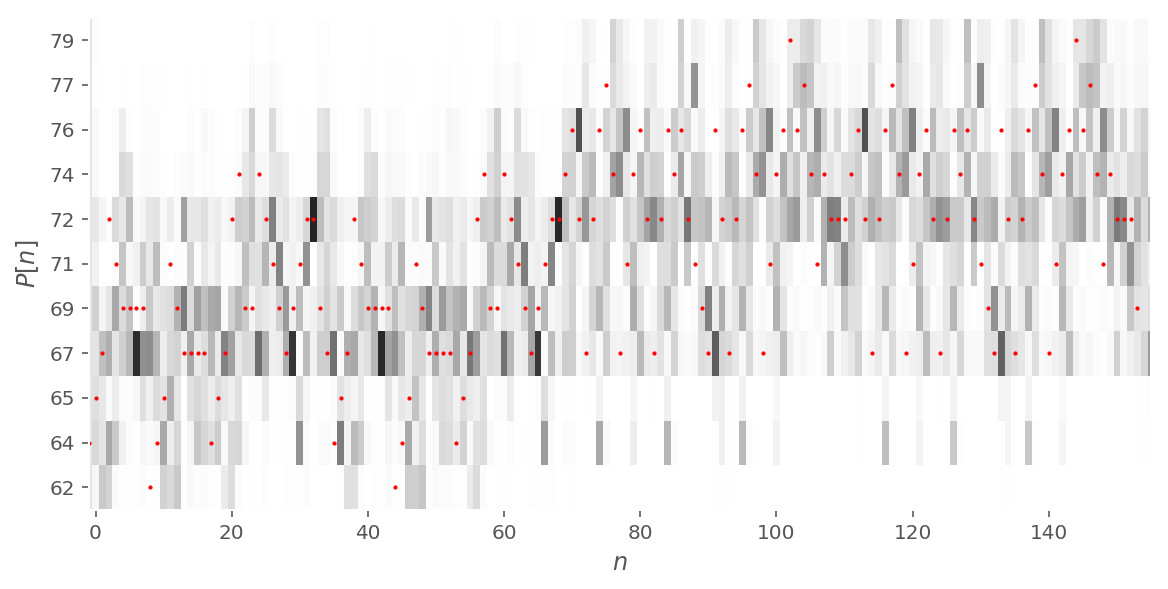

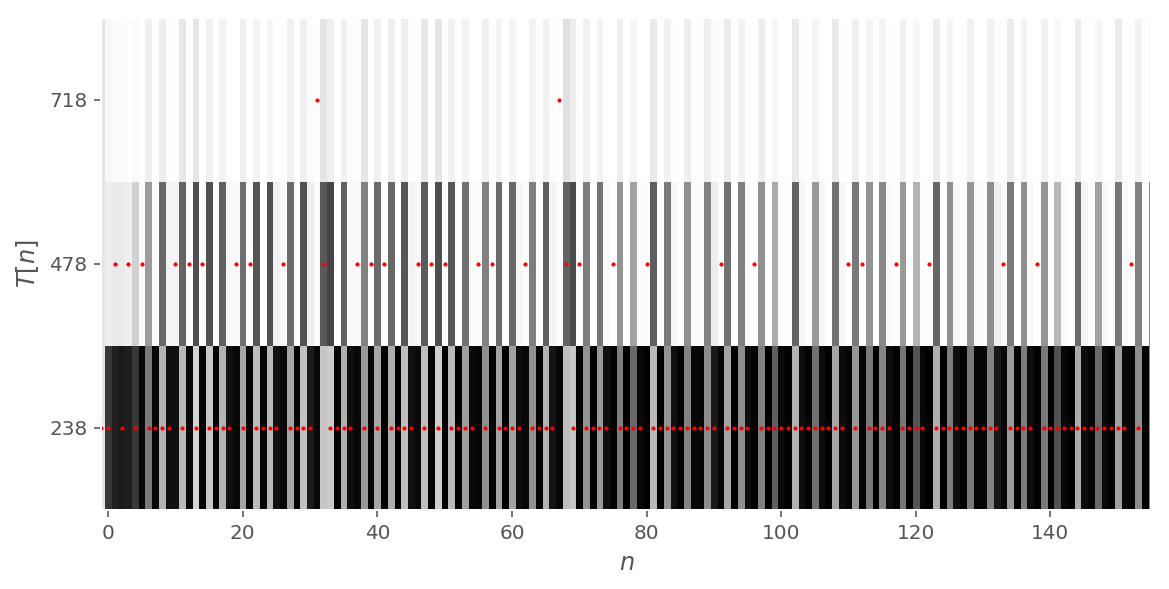

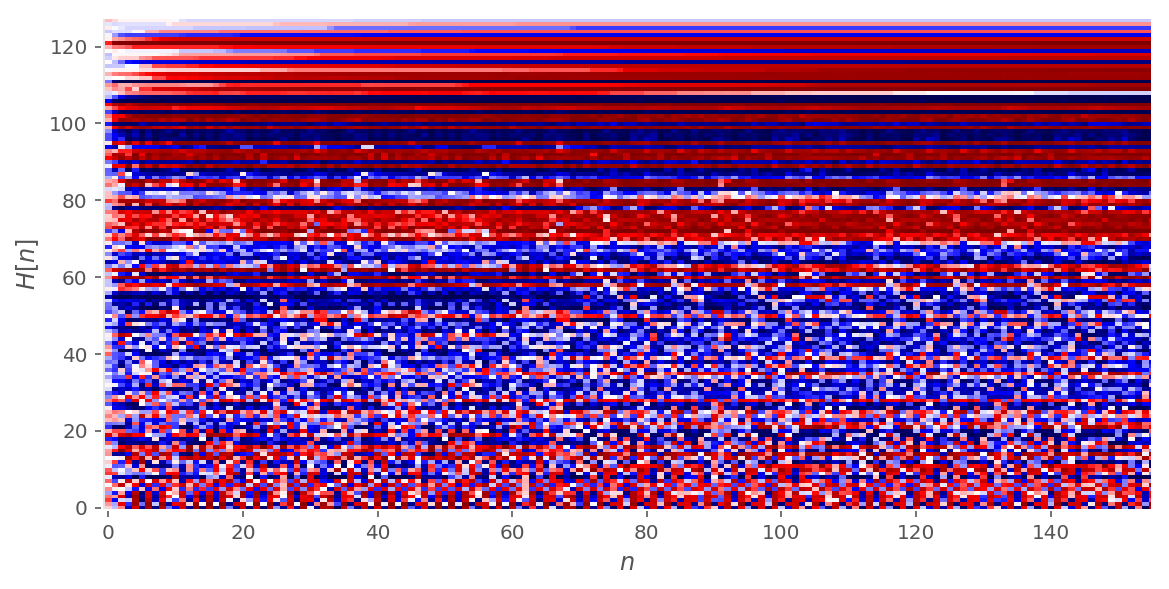

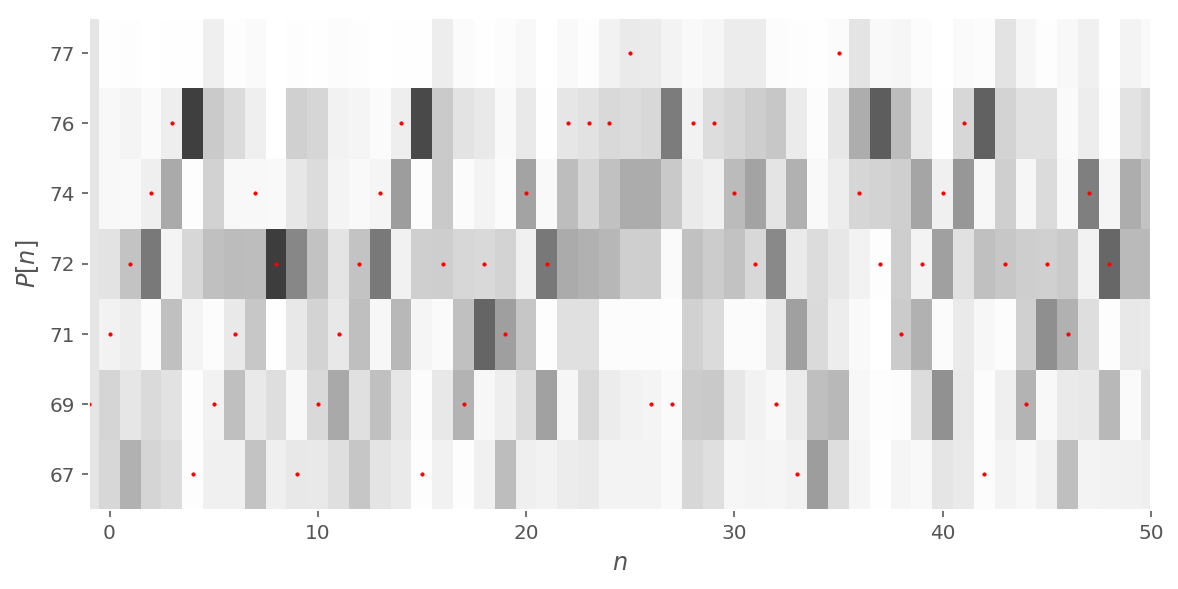

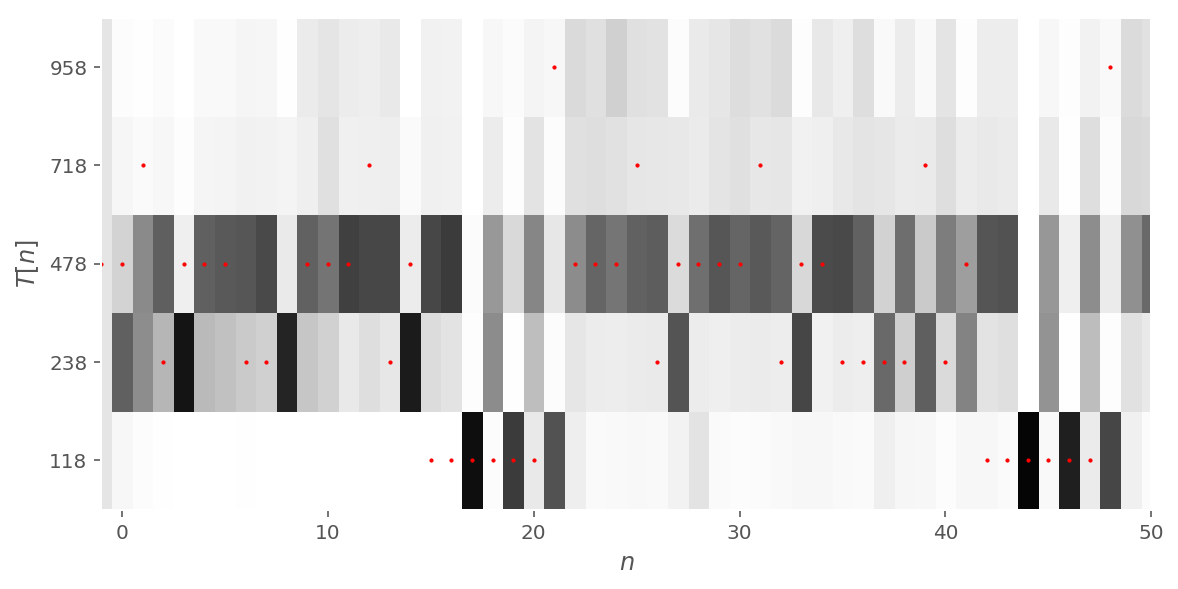

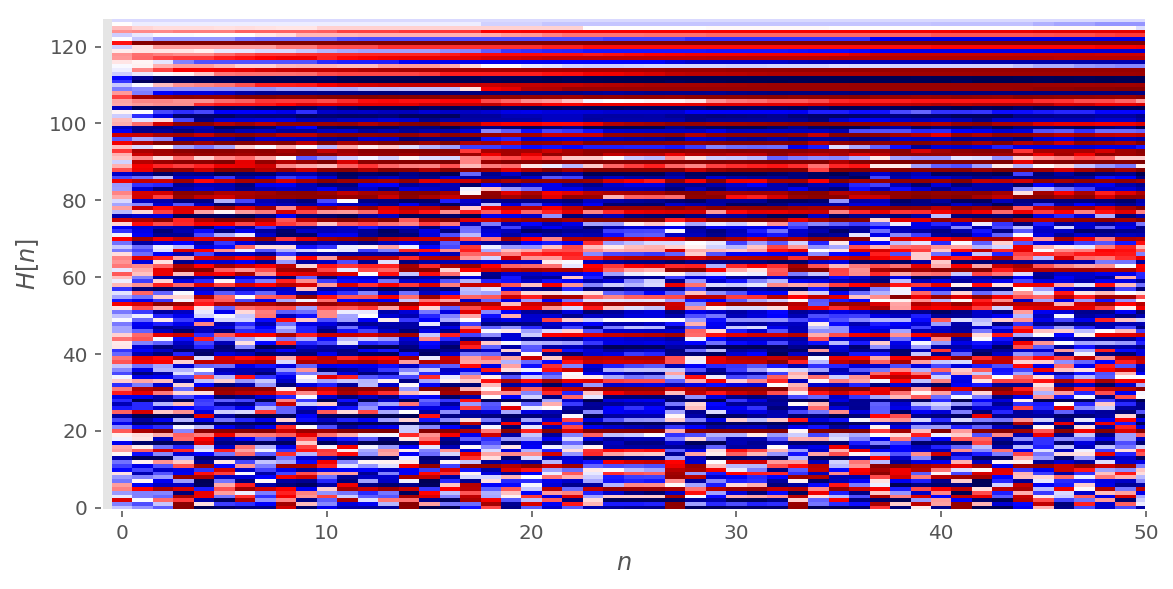

In [90]:
for i in range(0,NUM_MELODY):
    plotMelody(Y['P'][i], Y['T'][i], dictionaries_inv, PrP=PrP[i], PrT=PrT[i], H=h[i])

### 3

For each hidden unit  ii  and accross the entire dataset, compute the average absolute change in activation  ΔAiΔAi . Be careful not to take masked timesteps into account. Plot the histogram (50 bins) of this average for the RNN and GRU models on the same figure.

In [61]:
X = {}
Y = {}

X['T'] = np.zeros((len(dataset), batch_length-1, len(dictionaries['T'])))
X['P'] = np.zeros((len(dataset), batch_length-1, len(dictionaries['P'])))

for i, label in enumerate(list(dataset.keys())):

    X['T'][i] = dataset[label]['T'][:-1]
    X['P'][i] = dataset[label]['P'][:-1]
    
x = [X['T'], X['P']]

In [65]:
length_melody = length_melodies(X['T'])

In [66]:
layer_name = 'simple_rnn_1'
intermediate_layer_model = Model(inputs=RNNmodel.input,
                                 outputs=RNNmodel.get_layer(layer_name).output)
H_RNN = intermediate_layer_model.predict(x)

In [67]:
# get the hidden unit for the whole datasset for GRU
layer_name = 'gru_1'
intermediate_layer_model = Model(inputs=GRUmodel.input,
                                 outputs=GRUmodel.get_layer(layer_name).output)

H_GRU = intermediate_layer_model.predict(x)

In [68]:
def absolute_change(H, length_melody, len_dataset):
    avg_change_per_timesteps = np.zeros([1,H.shape[2]-1])
    
    # for each meoldy
    for i, h in enumerate(H):
        avg_change_per_timesteps += np.sum(np.abs(np.diff(h[:length_melody[i]-1])), axis=0)/length_melody[i]

    # for entire dataset
    delta_A = avg_change_per_timesteps/len_dataset
    
    return delta_A.ravel()

In [69]:
delta_A_RNN = absolute_change(H_RNN, length_melody, len(dataset))
delta_A_GRU = absolute_change(H_GRU, length_melody, len(dataset))

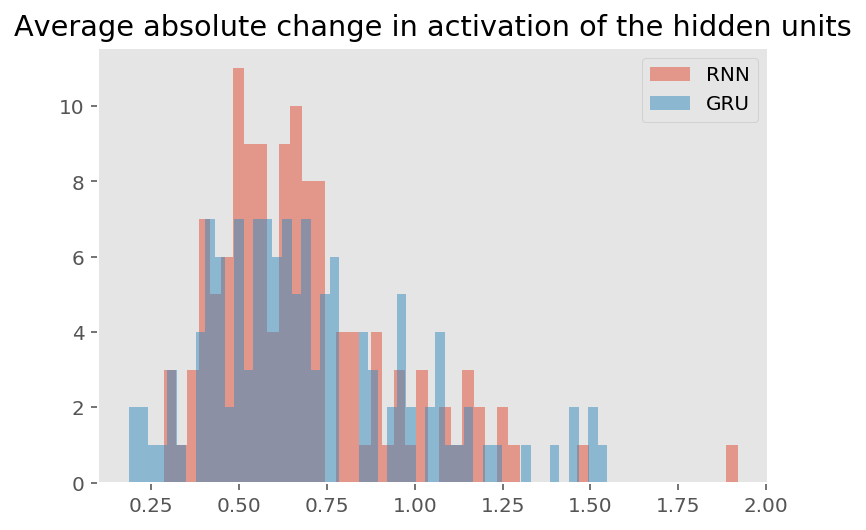

In [80]:
from matplotlib import pyplot

pyplot.title("Average absolute change in activation of the hidden units")
pyplot.hist(delta_A_RNN, bins = 50, alpha=0.5, label='RNN')
pyplot.hist(delta_A_GRU, bins = 50, alpha=0.5, label='GRU')
pyplot.legend(loc='upper right')
pyplot.show()

**Question**: How does the hidden state dynamics explain the performance of the RNN vs GRU models? Explain in term of temporal dependencies and base your explanation on figures obtained in 6.2 and 6.3.
    
**Answer**: Like it was said on the moodle forum, GRU should be slower in state changes than standard 'vanilla' RNN. However from my plot we can not really see clearly that difference.


## Exercise 7: Generation of new melodies
### Description

1. Use your trained best model to generate new melodies. You can do that by starting with a random note, feeding it to your network and sample the output predictions in order to select the next note. Then add this note to your iteratively growing melodies. For your convenience, we provided the `sample` and `writeMIDI` functions. You can use the first in order to perform temperature sampling. The `writeMIDI` function allows you to write a MIDI file from the integer representation.
2. Try different sampling temperatures (e.g. 0.5, 1., 1.5) and observe the effect on your generated melodies.
3. Generate 32 melodies with both the RNN and GRU models
4. Listen to 4 randomly chosen melodies (2 from the GRU model and 2 from the RNN model). To play in a notebook, use a similar approach as the one shown below assuming you have the files `GRU_1.mid` and `RNN_1.mid` at the same level as this notebook. For your own curiosity, you can also directly listen to the MIDI files with your favorite MIDI player but make sure that we can listen to the 4 extracts directly from this notebook (without rerunning it). You might have to use the "Trust notebook" button (in the top right corner) to see the players. This currently only works in jupyter notebook (not jupyter lab). If you have trouble achieving that, upload the MIDI files with your submission.
5. (Optional) If you have a big enough computing power, try adding multiple and bigger layers. You could also try to improve your model with different add-ons, e.g. make your model learn when a melody ends, extend it to other datasets, ...
6. (Optional) If you are happy with your results submit a 1 hour long generated MIDI file to the [AI-generated music challenge](https://www.crowdai.org/challenges/ai-generated-music-challenge). 

### Solution

In [41]:
def generate_melody(model, batch_length, dictionaries, length_melody, t_T, t_P):
    X = {}
    X['T'] = np.zeros((1, batch_length-1, len(dictionaries['T'])))
    X['P'] = np.zeros((1, batch_length-1, len(dictionaries['P'])))

    Y = {}
    Y['T'] = np.zeros((1, batch_length-1, len(dictionaries['T'])))
    Y['P'] = np.zeros((1, batch_length-1, len(dictionaries['P'])))

    xT = []
    xP = []

    # the first note is a special case, we choose a random duration and pitch
    X['T'][0][0] = keras.utils.to_categorical(np.random.randint(0,len(dictionaries['T'])),len(dictionaries['T']))
    X['P'][0][0] = keras.utils.to_categorical(np.random.randint(0,len(dictionaries['P'])),len(dictionaries['P']))
    xT.append(np.argmax(X['T'][0][0]))
    xP.append(np.argmax(X['P'][0][0]))

    # predict the next note
    x = [X['T'], X['P']]
    PrT, PrP = model.predict(x)

    for i in range(1, length_melody):
        predT = sample(PrT[0][i],t_T)
        X['T'][0][i] = keras.utils.to_categorical(predT,len(dictionaries['T']))
        xT.append(np.argmax(X['T'][0][i]))

        predP = sample(PrP[0][i],t_P)
        X['P'][0][i] = keras.utils.to_categorical(predP,len(dictionaries['P']))
        xP.append(np.argmax(X['P'][0][i]))

        x = [X['T'], X['P']]
        PrT, PrP = RNNmodel.predict(x)
    
    return xP, xT

In [42]:
# generate with RNN
for i in range(0,32):
    # we generate random length melody
    length_melody = np.random.randint(200,batch_length) 
    t_T = 1.5*np.random.rand()
    t_P = 1.5*np.random.rand()
    xP, xT = generate_melody(RNNmodel, batch_length, dictionaries, length_melody, t_T, t_P)
    writeMIDI(xP, xT, dictionaries_inv, "./gen/RNN/RNN_"+ str(i+1) + '_t' + str(round(t_T,1)) + '_p' + str(round(t_P,1)) + ".mid")

In [71]:
# generate with GRU
for i in range(0,32):
    # we generate random length melody
    length_melody = np.random.randint(200,batch_length) 
    t_T = 1.5*np.random.rand()
    t_P = 1.5*np.random.rand()
    xP, xT = generate_melody(GRUmodel, batch_length, dictionaries, length_melody, t_T, t_P)
    writeMIDI(xP, xT, dictionaries_inv, "./gen/GRU/GRU_"+ str(i+1) + '_t' + str(round(t_T,1)) + '_p' + str(round(t_P,1)) + ".mid")

In [52]:
print('RNN')
for label in np.random.choice(os.listdir("./gen/RNN/"), 2):
    print(label)
    music21.midi.translate.midiFilePathToStream("./gen/RNN/"+label).show('midi')

RNN
RNN_18_t0.4_p0.7.mid


RNN_3_t0.5_p1.4.mid


In [44]:
print('GRU')
for label in np.random.choice(os.listdir("./gen/GRU/"), 2):
    print(label)
    music21.midi.translate.midiFilePathToStream("./gen/GRU/"+label).show('midi')

GRU
GRU_2_t0.9_p1.4.mid


GRU_3_t0.3_p1.5.mid


**Question**: What is the effect of the sampling temperature on the generated melodies?
    
**Answer**: sampling with low temperature yield melodies with simple and more structured pattern. On the other hand with high temperature the melodies are more complex (random)

**Question**: Are the generated melodies from the RNN model different from the one generated by the GRU model? If yes, what are the main differences?

**Answer**: melodies genereated by GRU seems better (more harmonious).

